In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import iminuit as minuit


import scipy
from matplotlib import gridspec

from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy import optimize
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chisquare
from iminuit import cost
import warnings
warnings.filterwarnings('ignore')
from lmfit.models import SkewedGaussianModel



In [16]:
### reading in data and calibrating
def readDS(filename, calibration_file):
   # print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        #print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        #print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start

### guassian fit
def onepeak(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) 

def twopeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

### reading rutherfords
def readRuth(filename, detector):
    """ print comment lines from the lmd file """
    #print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        #print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        #print(comments)
    
    """ C1 data has a chopper flag column, DS and C2 don't """
    if detector == 'ruthE':
        temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None, usecols = np.arange(0,5))
        temp.columns = ['name', 'det', 't', 'evt_num', 'Ruth']
        
        
    return temp, start

    return temp, start
def onepeak_error(x, par):
    return par[0]*(np.exp((-1.0/2.0)*(((x-par[1])/par[2])**2))) 
def twopeaks_error(x, par):
    return par[0]*(np.exp((-1.0/2.0)*(((x-par[1])/par[2])**2))) +par[3]*(np.exp((-1.0/2.0)*(((x-par[4])/par[5])**2))) 

## Methide

### f038, NoCH3, no gas, A/q = 269/1

<bound method NDFrame._add_numeric_operations.<locals>.max of 0           110.091170
1           110.095420
2           110.095420
3           110.105084
4           110.158479
              ...     
934930    15094.743647
934931    15094.778591
934932    15094.782768
934933    15094.787030
934934    15094.800229
Name: t, Length: 934935, dtype: float64>


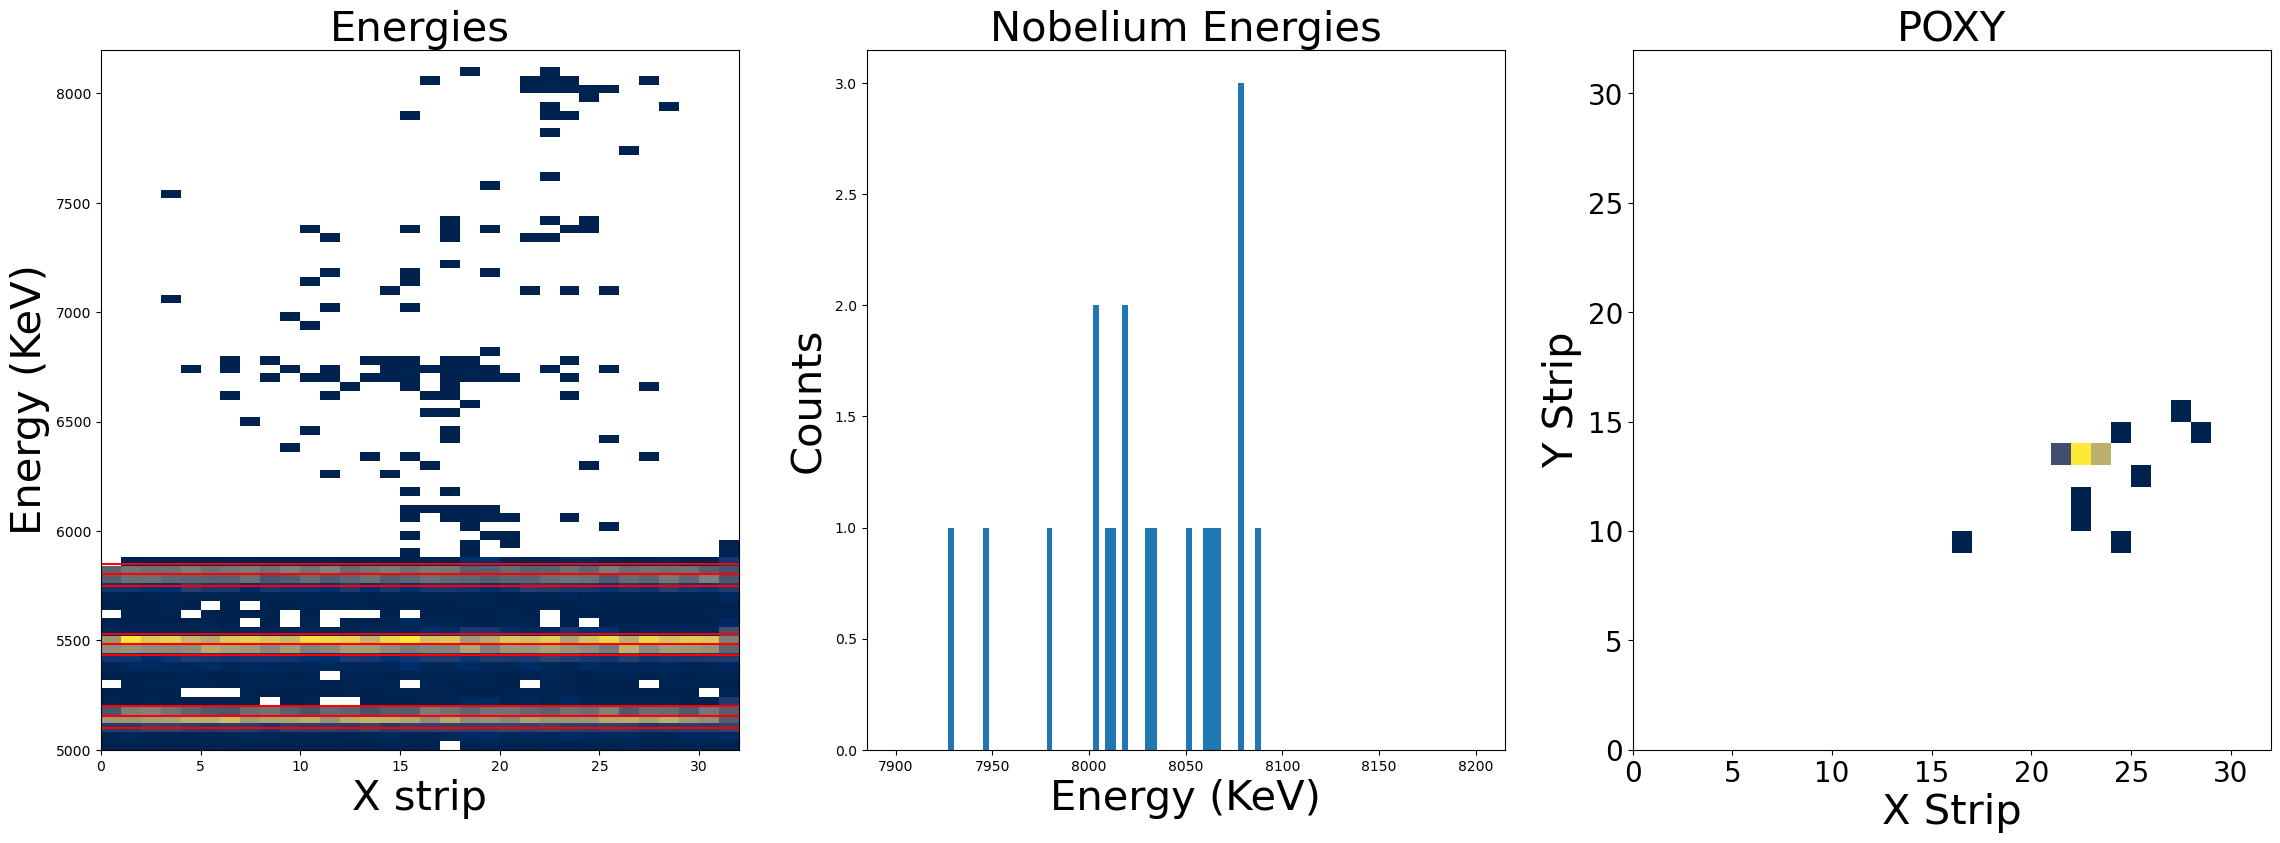

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.133 (chi2/ndof = 0.8)    │              Nfcn = 176              │
│ EDM = 4.89e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

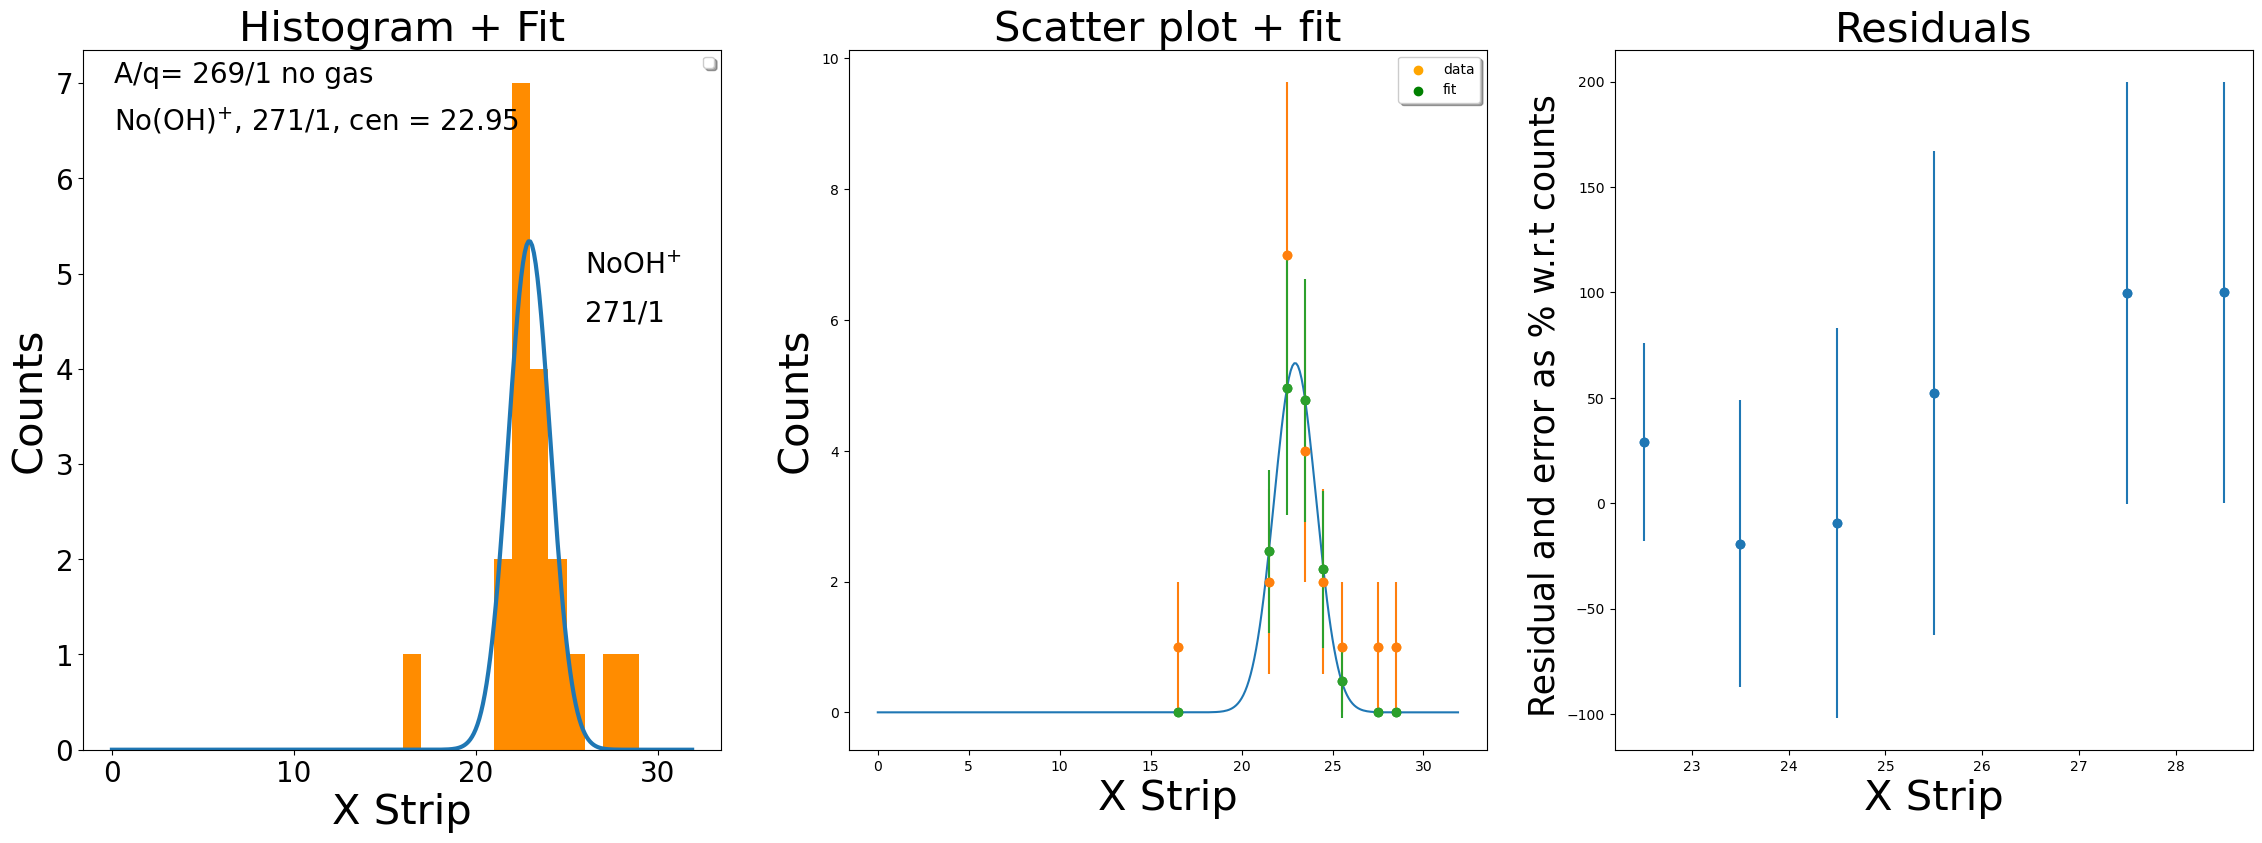

In [17]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

data = pd.read_csv('run231_038_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
print (data['t'].max)
df, t1 = readDS('run231_038_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('X strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data 
gates = df[(df['y'] >=9) & (df['y'] < 21) & (df['xE'] > 7900) & (df['xE']<8500)]


### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram and fit
xbins = range(0,32)
hist= plt.hist(gates['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,onepeak)
m= minuit.Minuit(c,7,25,1)
m.limits=((0,None), (20.5,30),(0,2))
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
yy= onepeak(bins_,amp_1,cen_1,exp_1)
yy_=onepeak(newBins_change,amp_1,cen_1,exp_1)
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.plot(bins_,yy,linewidth=3)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(.1,6.5,  "No(OH)$^{+}$, 271/1, cen = 22.95", fontsize = 20)
plt.text(.1,7, "A/q= 269/1 no gas", fontsize = 20)
plt.text(26,5, "NoOH$^{+}$", fontsize = 20)
plt.text(26,4.5, "271/1", fontsize = 20)




### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [onepeak_error(newBins_change, p) for p in par_b]
error =np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)
#plt.axvline(15.88,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
#plt.axvline(22.44,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp. line')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)



### scatter plot with fit
plt.subplot(2,3,5)
plt.plot(bins_,yy)
c_= np.sqrt(newcounts)
plt.title("Scatter plot + fit", fontsize = 30)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label='fit',color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= "o")
plt.legend(loc='upper right', shadow=True)



### Residuals
residual = (newcounts - yy_)/newcounts*100
residual_errors=np.sqrt(np.sqrt(newcounts)**2+error**2)/newcounts*100
plt.subplot(2,3,6)
plt.title("Residuals", fontsize = 30)
plt.scatter(newBins_change[2:23],residual[2:23])
plt.errorbar(newBins_change[2:23],residual[2:23], yerr=residual_errors[2:23], fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual and error as % w.r.t counts ',fontsize = 25)

### How many counts in peak, area of the peak
area1_7=amp_1*exp_1/.3989

### print m. values
print (m.migrad())


### Rutherford Number, East
dfR_0, t1R = readRuth('run231_038_output_Ruth.txt', 'ruthE')
print(" Number of Rutherfords? = %0.10f" % (len(dfR_0)))
error_Ruth=np.sqrt(len(dfR_0))



### CPR
CPR_OH_nogas= area1_7/len(dfR_0)*1000
error_OH_noba= CPR_OH_nogas*np.sqrt(1/area1_7+1/len(dfR_0))

print(" Counts per 1k ruth ? = %0.10f (+/-) %0.10f" % (CPR_OH_nogas,error_OH_noba))



### f039, 269/1, No Methide, with gas

<bound method NDFrame._add_numeric_operations.<locals>.max of 0            145.836437
1            145.855017
2            145.871112
3            145.874213
4            145.881155
               ...     
1438110    23158.069248
1438111    23158.088372
1438112    23158.088534
1438113    23158.134816
1438114    23158.137715
Name: t, Length: 1438115, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.max of 0          394.827888
1          394.844156
2          394.883561
3          394.886505
4          394.890010
             ...     
355651    6097.222739
355652    6097.253543
355653    6097.265501
355654    6097.280871
355655    6097.283894
Name: t, Length: 355656, dtype: float64>


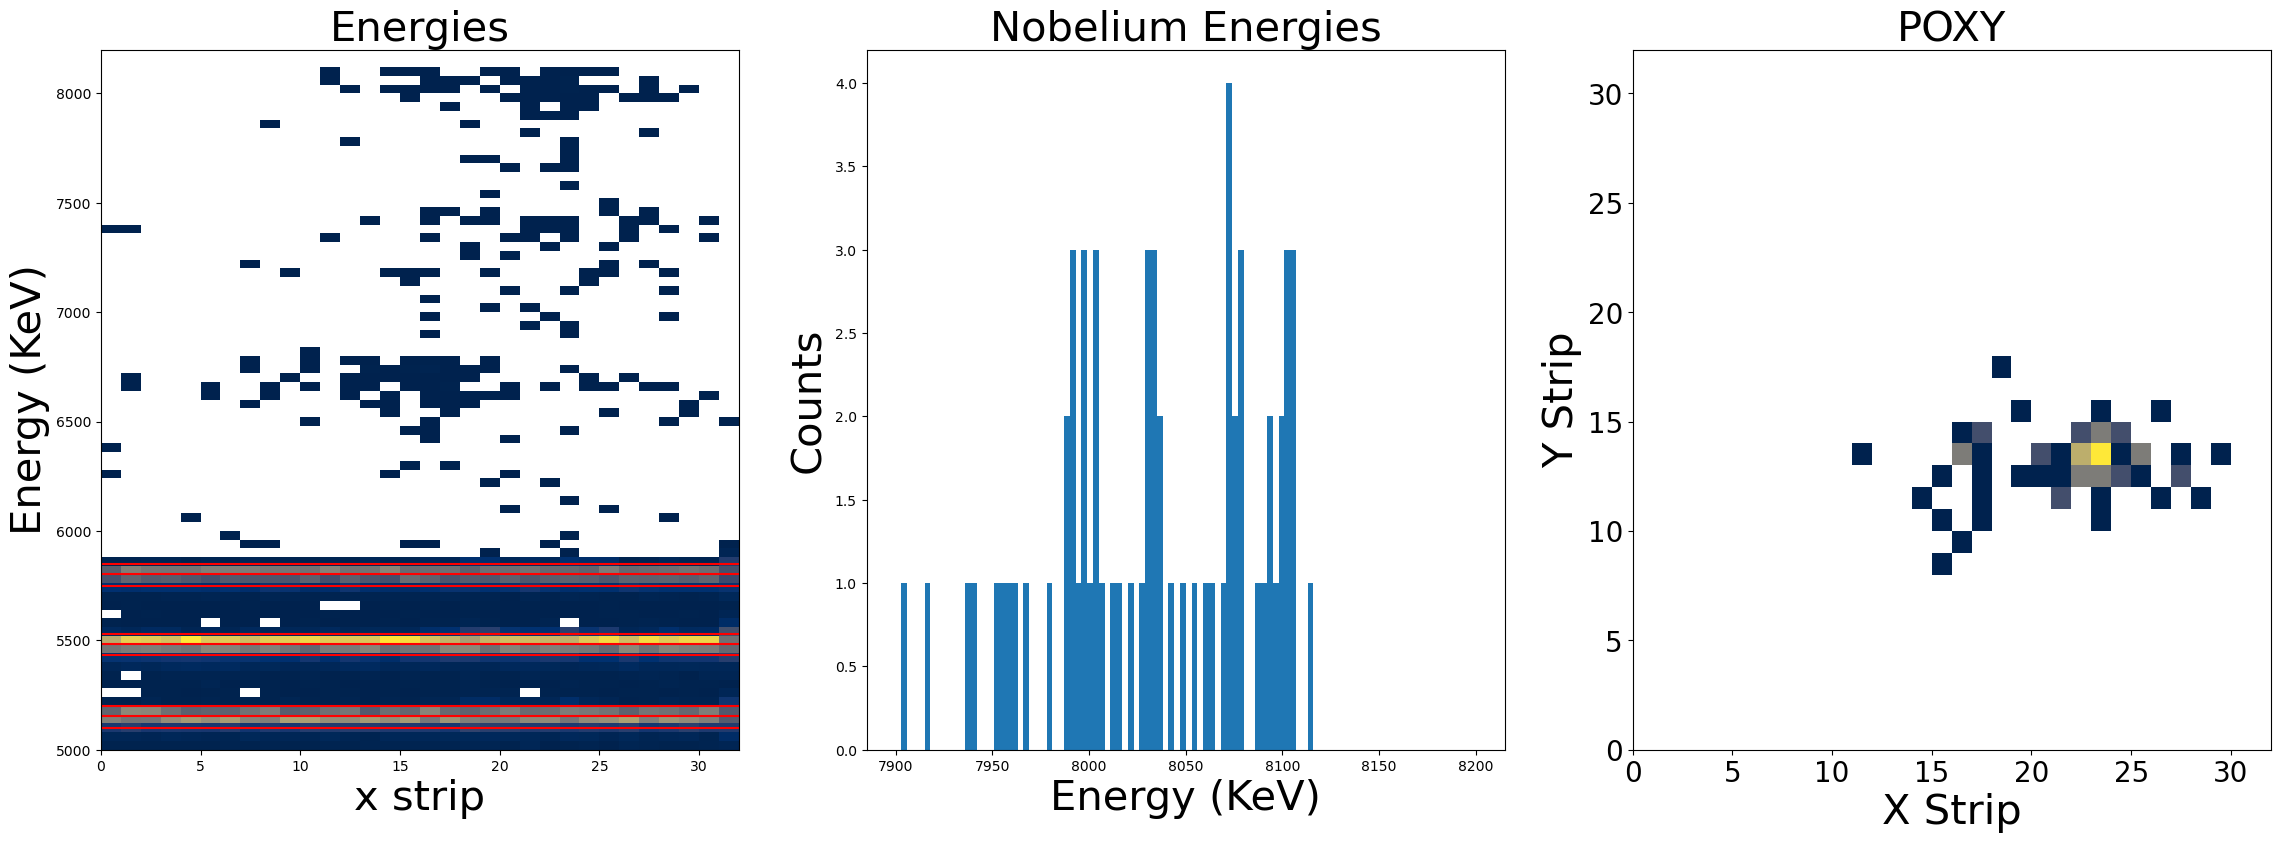

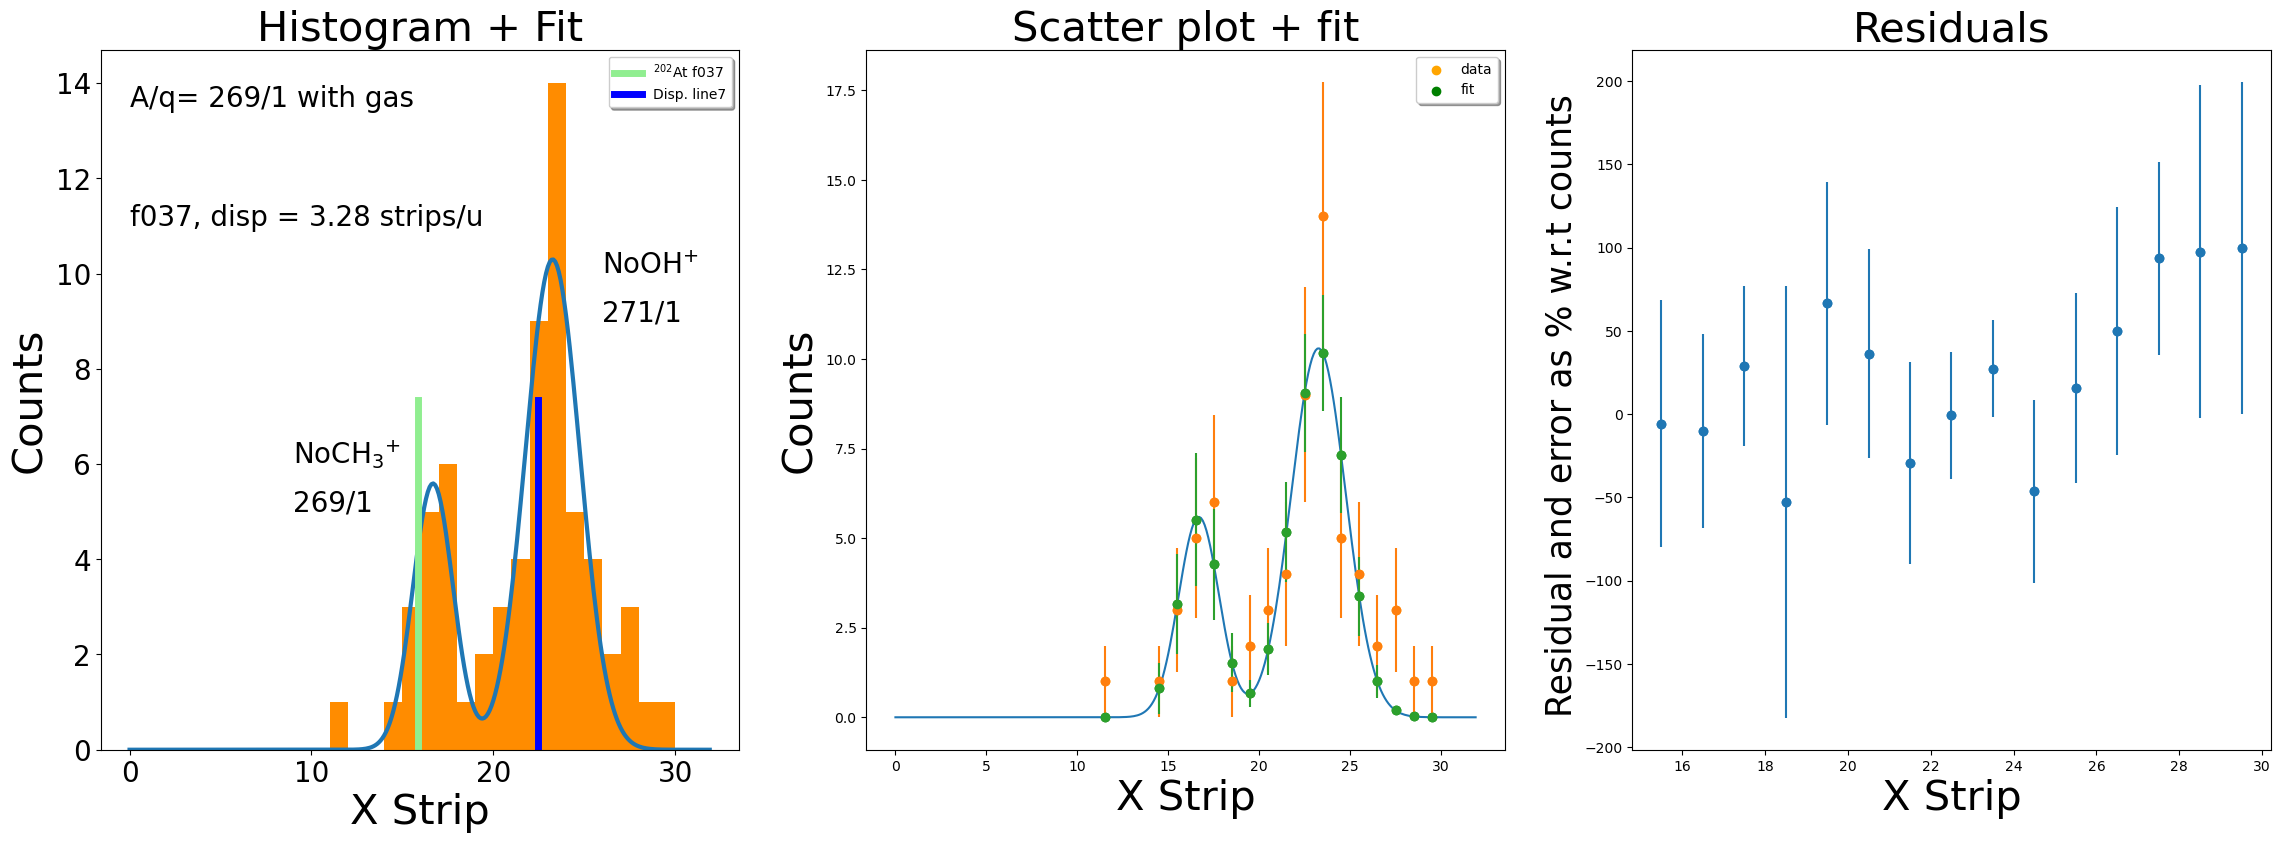

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.81 (chi2/ndof = 1.0)    │              Nfcn = 222              │
│ EDM = 7.32e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

In [18]:

cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
data_1 = pd.read_csv('run231_039_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
data_2 = pd.read_csv('run231_039_2_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
data = pd.concat([data_1,data_2])
print (data_1['t'].max)
print (data_2['t'].max)



df2_1, t2_1 = readDS('run231_039_output.txt', cal)
df2_2, t2_2 = readDS('run231_039_2_output.txt', cal)
df2 = pd.concat([df2_1,df2_2])


### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df2['x'], df2['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_2 = df2[(df2['y'] >=8) & (df2['y'] < 18) & (df2['xE'] > 7900) & (df2['xE']<8400)]



### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_2['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY
plt.subplot(2,3,3)
plt.hist2d(gates_2['x'], gates_2['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram and fit
xbins = range(0,32)
hist= plt.hist(gates_2['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,twopeaks)
m= minuit.Minuit(c,6,15,1,14,24,1.2)
m.limits = [(None,None),(None,None),(0,1.5),(0,None), (0, None),(0,1.5)]
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
yy= twopeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=twopeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
#print(yy)
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.plot(bins_,yy,linewidth=3)
plt.bar(bins,counts, width=1.0,color='darkorange')

plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
#plt.text(0.01,13, "No(OH)$^{+}$, 271/1, cen = 22.7", fontsize = 20)
plt.text(0,13.5, "A/q= 269/1 with gas", fontsize = 20)
plt.text(26,10, "NoOH$^{+}$", fontsize = 20)
plt.text(26,9, "271/1", fontsize = 20)#plt.text(0.01,12, "No(CH)$_3$$^{+}$, 269/1, cen = 16.18", fontsize = 20)
plt.text(9,6, "NoCH$_{3}$$^{+}$", fontsize = 20)
plt.text(9,5, "269/1", fontsize = 20)#plt.text(0.01,12, "No(CH)$_3$$^{+}$, 269/1, cen = 16.18", fontsize = 20)
plt.text(.01,11, "f037, disp = 3.28 strips/u", fontsize = 20)
plt.axvline(15.88,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
plt.axvline(22.44,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp. line7')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)





### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [twopeaks_error(newBins_change, p) for p in par_b]
error = np.sqrt(1)*np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)
#plt.axvline(15.88,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
#plt.axvline(22.44,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp. line')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)



### scatter plot with fit
plt.subplot(2,3,5)
plt.plot(bins_,yy)
c_= np.sqrt(newcounts)
plt.title("Scatter plot + fit", fontsize = 30)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label='fit',color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= "o")
plt.legend(loc='upper right', shadow=True)



### Residuals
residual = (newcounts - yy_)/newcounts*100
residual_errors=np.sqrt(np.sqrt(newcounts)**2+error**2)/newcounts*100
plt.subplot(2,3,6)
plt.title("Residuals", fontsize = 30)
plt.scatter(newBins_change[2:23],residual[2:23])
plt.errorbar(newBins_change[2:23],residual[2:23], yerr=residual_errors[2:23], fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual and error as % w.r.t counts ',fontsize = 25)


plt.show()
### How many counts in peak, area of the peak
area1_6=amp_1*exp_1/.3989
area2_6=amp_2*exp_2/.3989




print (m.migrad())

### Rutherford Number, East
dfRuth_2_0, t1Ruth_2_0 = readRuth('run231_039_output_Ruth.txt', 'ruthE')
dfRuth_2_1, t1Ruth_2_1 = readRuth('run231_039_2_output_Ruth.txt', 'ruthE')
dfRuth_2 = pd.concat([dfRuth_2_0,dfRuth_2_1])
print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_2)))

### Counts per 1k ruth (CPR)
CPR_Methide = area1_6/len(dfRuth_2)*1000
error_Ruth_2=np.sqrt(len(dfRuth_2))
error_CPR_Methide= CPR_Methide*np.sqrt(1/area1_6+1/len(dfRuth_2))
CPR_OH = area2_6/len(dfRuth_2)*1000
error_OH= CPR_OH*np.sqrt(1/area2_6+1/len(dfRuth_2))


print(" Counts per 1k ruth (CPR_Methide)= %0.10f (+/-) %0.10f" % (CPR_Methide,error_CPR_Methide))
print(" Counts per 1k ruth (CPR_OH)= %0.10f (+/-) %0.10f" % (CPR_OH,error_OH))






### f071, Looking for NoC$_{4}$H$_{8}$$^{2+}$, A/q= 310/2, with gas

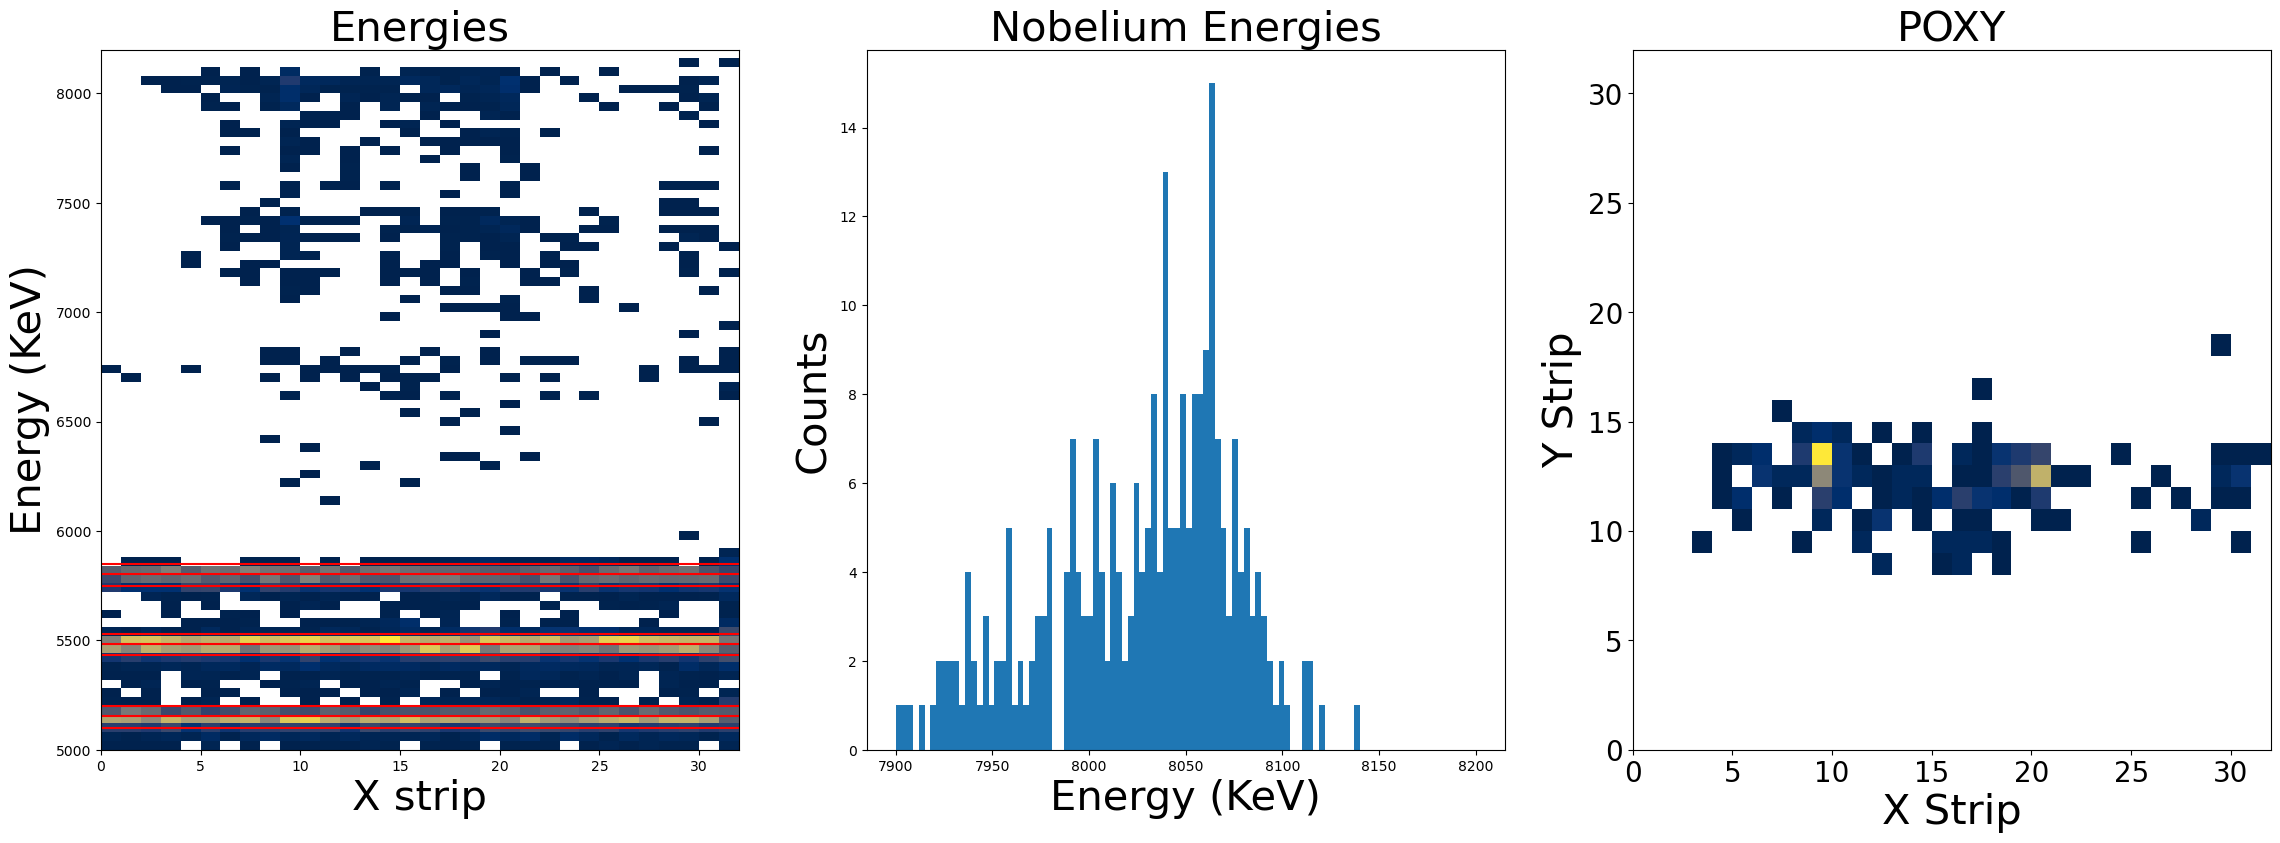

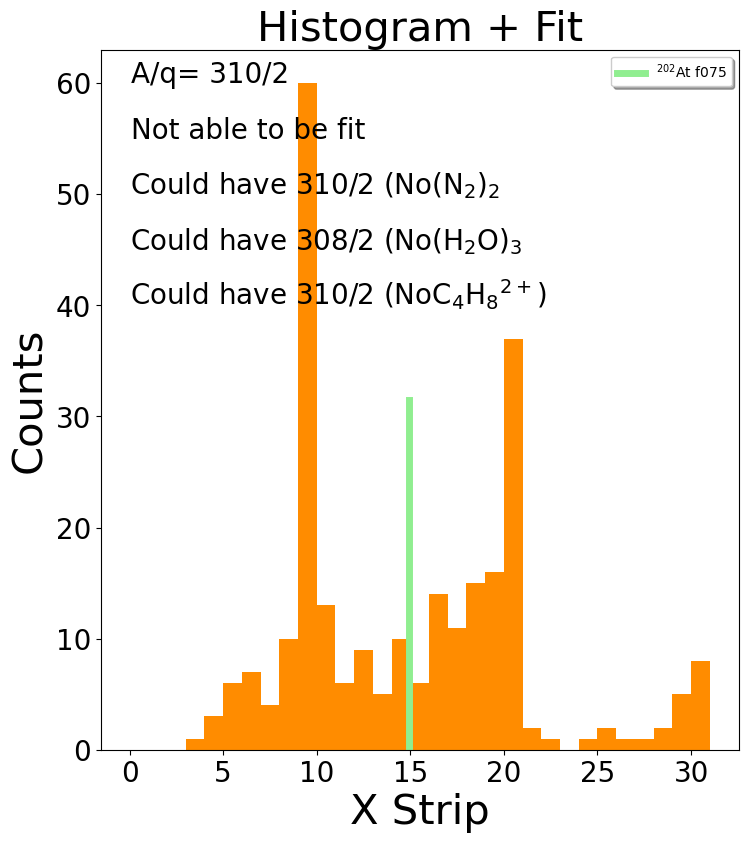

In [19]:
cal = pd.read_csv('run231_calibration_run075.txt', sep = '\t', index_col = 0)

df_p2, t1_p2 = readDS('run231_071_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df_p2['x'], df_p2['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('X strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_p2 = df_p2[(df_p2['y'] >=8) & (df_p2['y'] < 21) & (df_p2['xE'] > 7900) & (df_p2['xE']<8500)]

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_p2['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates_p2['x'], gates_p2['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram 
xbins = range(0,32)
hist= plt.hist(gates_p2['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(.1,55,  "Not able to be fit", fontsize = 20)
plt.text(.1,60, "A/q= 310/2", fontsize = 20)
plt.text(.01,50, "Could have 310/2 (No(N$_{2}$)$_{2}$", fontsize = 20)
plt.text(.01,45, "Could have 308/2 (No(H$_{2}$O)$_{3}$", fontsize = 20)
plt.text(.01,40, "Could have 310/2 (NoC$_{4}$H$_{8}$$^{2+}$)", fontsize = 20)
plt.axvline(14.91,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f075')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)




plt.show()




## 269/2, f065, with butane gas, proving methide is not coming in as a 2+

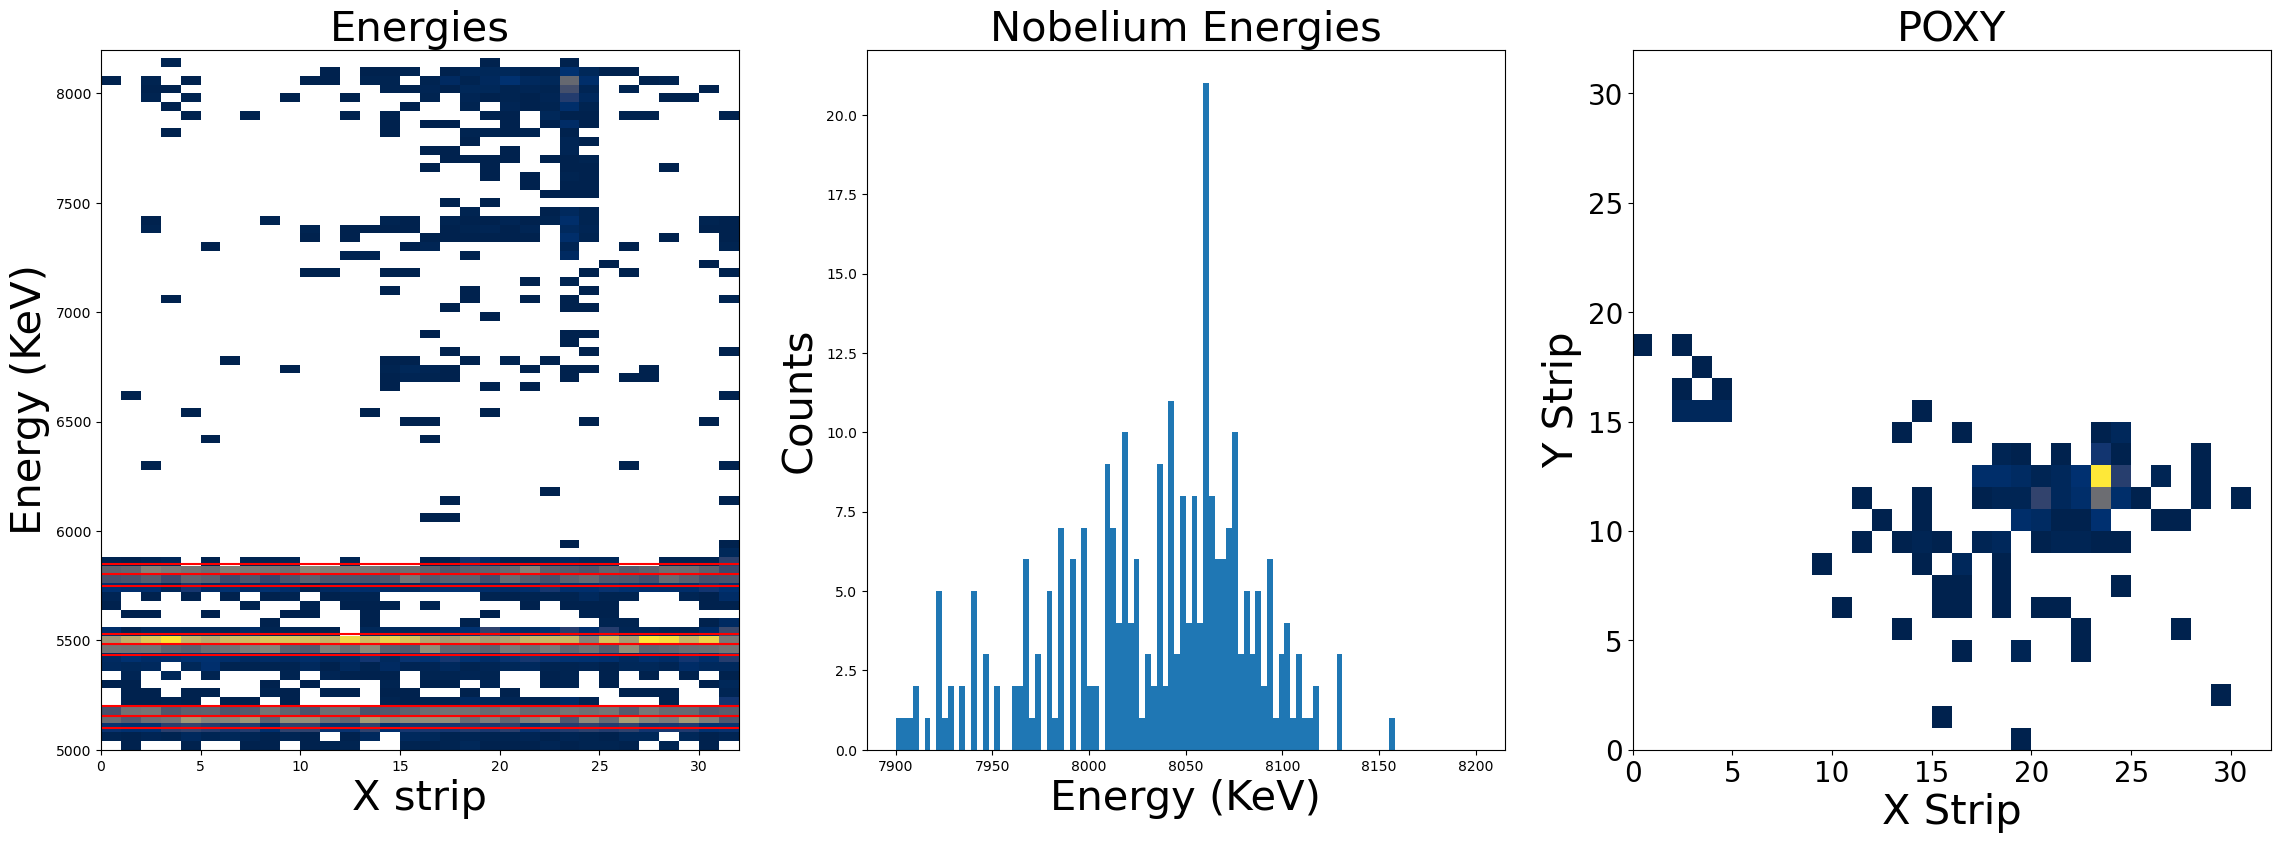

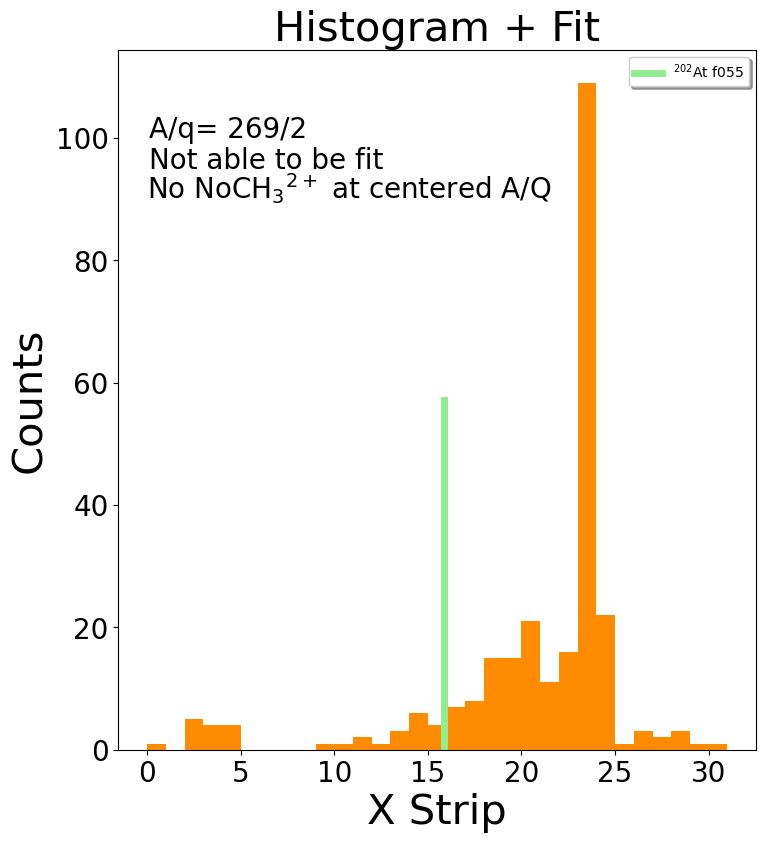

In [20]:
cal = pd.read_csv('run231_calibration_run055.txt', sep = '\t', index_col = 0)

df_p3, t1_p3 = readDS('run231_065_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df_p3['x'], df_p3['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('X strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_p3 = df_p3[(df_p3['y'] >=0) & (df_p3['y'] < 31) & (df_p3['xE'] > 7900) & (df_p3['xE']<8500)]

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_p3['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates_p3['x'], gates_p3['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram 
xbins = range(0,32)
hist= plt.hist(gates_p3['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(.1,95,  "Not able to be fit", fontsize = 20)
plt.text(.1,100, "A/q= 269/2", fontsize = 20)
plt.text(.01,90, "No NoCH$_{3}$$^{2+}$ at centered A/Q", fontsize = 20)
plt.axvline(15.88,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f055')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)




plt.show()




# Flouride

### f035, NoF Baseline, A/q = 273/1, no gas

13625.22075669999


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                    name det             t   evt_num   x   y  nX  nY  \
49938  r231f035_4843.lmd  DS  13623.071038  16855993  14   9   1   1   
49939  r231f035_4843.lmd  DS  13623.164255  16856003  12  14   1   1   
49940  r231f035_4843.lmd  DS  13624.321791  16856117   8  17   1   1   
49941  r231f035_4843.lmd  DS  13624.555633  16856144  17  23   1   1   
49942  r231f035_4843.lmd  DS  13624.937485  16856176   5   9   1   1   

                xE           yE  
49938  5136.653744  5169.062483  
49939  5486.973469  5501.972431  
49940  5509.152384  5524.723488  
49941  5512.193181  5523.253106  
49942  5409.813641  5433.865429  


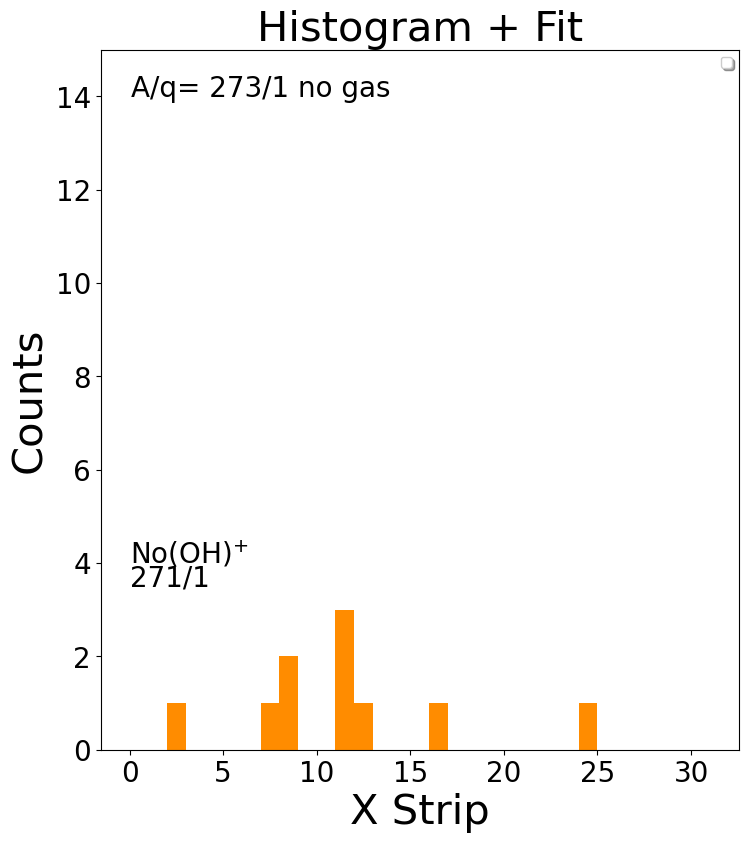

 Number of Rutherfords? = 134457.0000000000
 Counts per 1k ruth ? = 0.0743732197 (+/-) 0.0235197517 
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.104 (chi2/ndof = 0.8)    │              Nfcn = 244              │
│ EDM = 2.81e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴─

In [28]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

data = pd.read_csv('run231_035_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
print (data['t'].max())

df3, t13 = readDS('run231_035_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df3['x'], df3['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('X strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

print (df3.tail())
### Creating the gated data and bining
gates_3= df3[(df3['y'] >=9) & (df3['y'] < 21) & (df3['xE'] > 7900) & (df3['xE']<8500)]



### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_3['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates_3['x'], gates_3['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram
xbins = range(0,32)
hist= plt.hist(gates_3['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,onepeak)
m= minuit.Minuit(c,3,11,1)
m.limits=((0,None), (0,None),(0,2))
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
yy= onepeak(bins_,amp_1,cen_1,exp_1)
yy_=onepeak(newBins_change,amp_1,cen_1,exp_1)
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.bar(bins,counts, width=1.0,color='darkorange')
#plt.plot(bins_,yy,linewidth=3)
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.ylim(0,15)
plt.text(0.01,4, "No(OH)$^{+}$", fontsize = 20)
plt.text(0.01,3.5, "271/1", fontsize = 20)
plt.text(.1,14, "A/q= 273/1 no gas", fontsize = 20)
#plt.text(.03,13, "Disp.= 2.92 Strip/u, f037", fontsize = 20)
#plt.text(.1,12,  "Not able to be fit", fontsize = 20)
#plt.axvline(15.88,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
#plt.axvline(10.04,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp. Line')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)


plt.show()

### How many counts in peak, area of the peak
area_8=sum(newcounts)


### Rutherford Number, East
dfR_3, t1R_3 = readRuth('run231_035_output_Ruth.txt', 'ruthE')
print(" Number of Rutherfords? = %0.10f" % (len(dfR_3)))
error_Ruth_3=np.sqrt(len(dfR_3))


### CPR
CPR_3 = area_8/len(dfR_3)*1000
error_CPR_3= CPR_3*np.sqrt(1/area_8+1/len(dfR_3))

print(" Counts per 1k ruth ? = %0.10f (+/-) %0.10f " % (CPR_3,error_CPR_3))

print (m.migrad())





### f036, A/q = 273/1, NoF, with gas

<bound method NDFrame._add_numeric_operations.<locals>.max of 0          384.248310
1          384.258649
2          384.274581
3          384.278492
4          384.281819
             ...     
346021    5934.798525
346022    5934.808618
346023    5934.818429
346024    5934.819689
346025    5934.841685
Name: t, Length: 346026, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.max of 0            170.617545
1            170.628271
2            170.678677
3            170.686471
4            170.695843
               ...     
1408954    22717.974543
1408955    22717.978912
1408956    22718.011106
1408957    22718.014188
1408958    22718.049250
Name: t, Length: 1408959, dtype: float64>


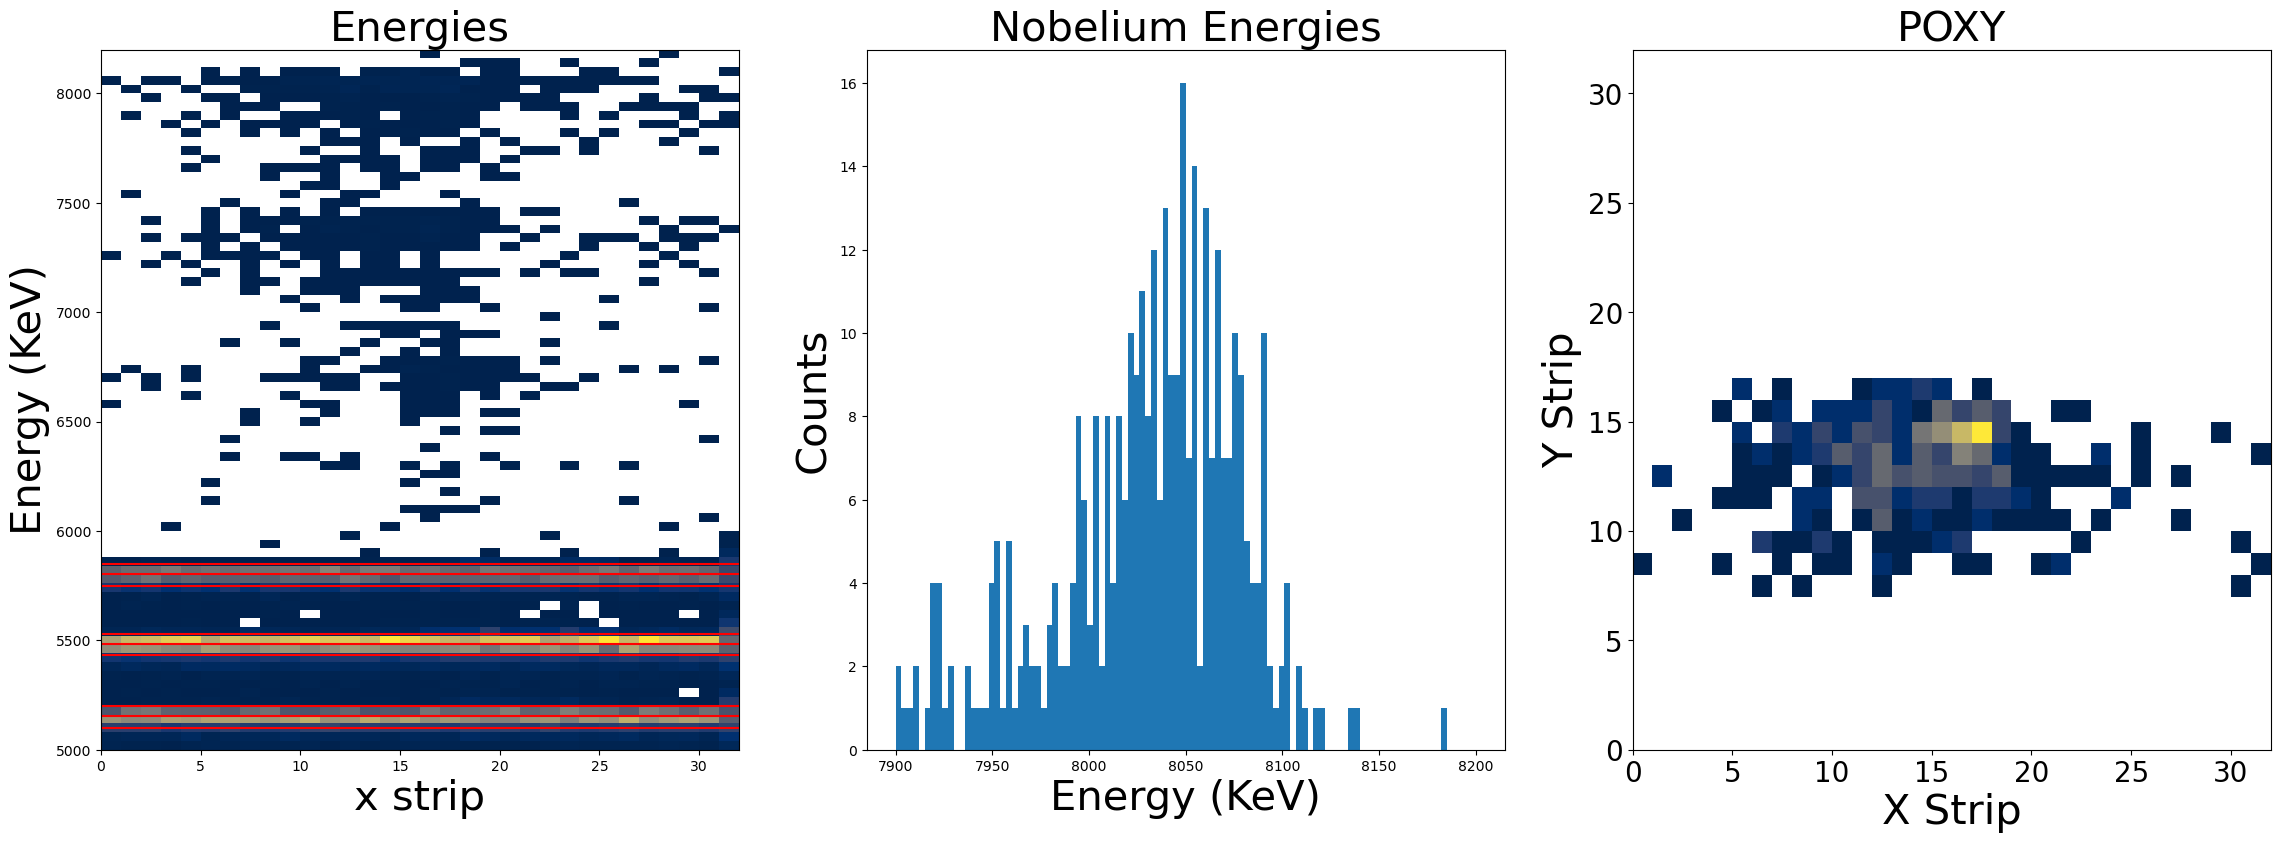

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 54.63 (chi2/ndof = 2.3)    │              Nfcn = 197              │
│ EDM = 2.54e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─

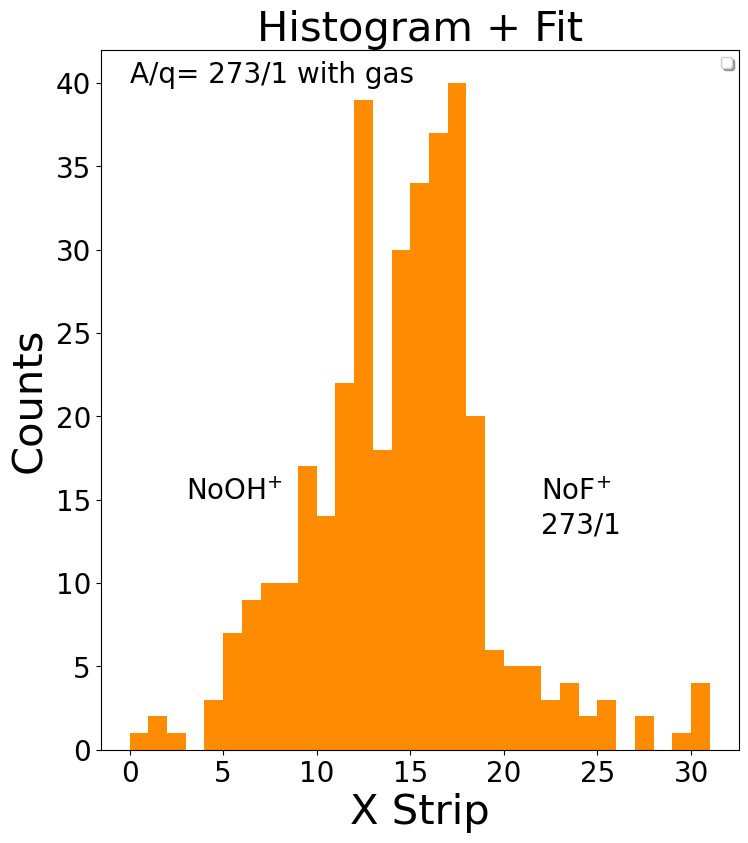

In [33]:
from scipy.integrate import quad
data_1 = pd.read_csv('run231_036_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
data_2 = pd.read_csv('run231_036_2_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
print (data_1['t'].max)
print (data_2['t'].max)


cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
df4_1, t4_1 = readDS('run231_036_output.txt', cal)
df4_2, t4_2 = readDS('run231_036_2_output.txt', cal)

df4 = pd.concat([df4_1,df4_2])

### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df4['x'], df4['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Creating the gated data and bining
gates_4 = df4[(df4['y'] >=7) & (df4['y'] < 17) & (df4['xE'] > 7900) & (df4['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_4['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,3,3)
plt.hist2d(gates_4['x'], gates_4['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram 
xbins = range(0,32)
hist= plt.hist(gates_4['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
#print(yy)
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.text(0,40, "A/q= 273/1 with gas", fontsize = 20)
plt.text(3,15, "NoOH$^{+}$", fontsize = 20)
plt.text(22,15, "NoF$^{+}$", fontsize = 20)
plt.text(22,13, "273/1", fontsize = 20)

#plt.axvline(15.88,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
#plt.axvline(10.04,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp. Line')

plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
from scipy.special import erf
def skewed_gaussian(x, mu, sigma, alpha, amplitude):
    norm_pdf =amplitude*np.exp(-0.5 * ((x - mu) / sigma) ** 2)*(1 + erf(alpha * (x - mu) / (sigma * np.sqrt(2))))
    return   norm_pdf

def likelihood(mu, sigma, alpha, amplitude):
    # Calculate the negative log-likelihood (or chi-square)
    neg_log_likelihood = -np.sum(np.log(skewed_gaussian(newBins_change, mu, sigma, alpha, amplitude)))
    return neg_log_likelihood
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,skewed_gaussian)


m= minuit.Minuit(c,mu=16, sigma=1.0, alpha=1.0, amplitude=40)
m.limits = [(10,20),(0,5),(-1.9,-1.7),(0,None)]
m.migrad()
print (m.migrad())
best_fit_mu = m.values['mu']
best_fit_sigma = m.values['sigma']
best_fit_alpha = m.values['alpha']
best_fit_amplitude = m.values['amplitude']

### plotting with OH adjusted
#plt.plot(bins_-0.5, skewed_gaussian(bins_, best_fit_mu, best_fit_sigma, best_fit_alpha, best_fit_amplitude))
area=7.2
cen=10.1
exp=0.93
yy= onepeak(bins_,area,cen,exp)
#plt.plot(bins_,yy,linewidth=3, color = "blue")


### Rutherford Number, East
dfR_4_1, t1R_4_1 = readRuth('run231_036_output_Ruth.txt', 'ruthE')
dfR_4_2, t1R_4_2 = readRuth('run231_036_2_output_Ruth.txt', 'ruthE')
dfR_4 = pd.concat([dfR_4_1,dfR_4_2])


### How many counts

#area1_9,_=scipy.integrate.quad(skewed_gaussian,0, 32, args=(best_fit_sigma, best_fit_mu, best_fit_alpha,best_fit_amplitude))
area1_9=sum(newcounts)
area2_9=CPR_3*len(dfR_4)/len(dfR_3)











error_Ruth_4=np.sqrt(len(dfR_4))


print(" Number of Rutherfords? = %0.10f" % (len(dfR_4)))

### CPR
CPR_4 = area1_9/len(dfR_4)*1000-area2_9/len(dfR_4)*100
error_CPR_4= np.sqrt((area1_9/len(dfR_4)*1000*np.sqrt(1/area1_9+1/len(dfR_4)))**2+(area2_9/len(dfR_4)*1000*np.sqrt(1/area2_9+1/len(dfR_4)))**2)







print(" Counts per 1k ruth flouride = %0.10f (+/-) %0.10f" % (CPR_4,error_CPR_4))
print(" Counts per 1k ruth OH ? = %0.10f (+/-) %0.10f " % (CPR_3*len(dfR_4)/len(dfR_3),error_CPR_3*len(dfR_4)/len(dfR_3)))

















# Using 290/1 as a baseline

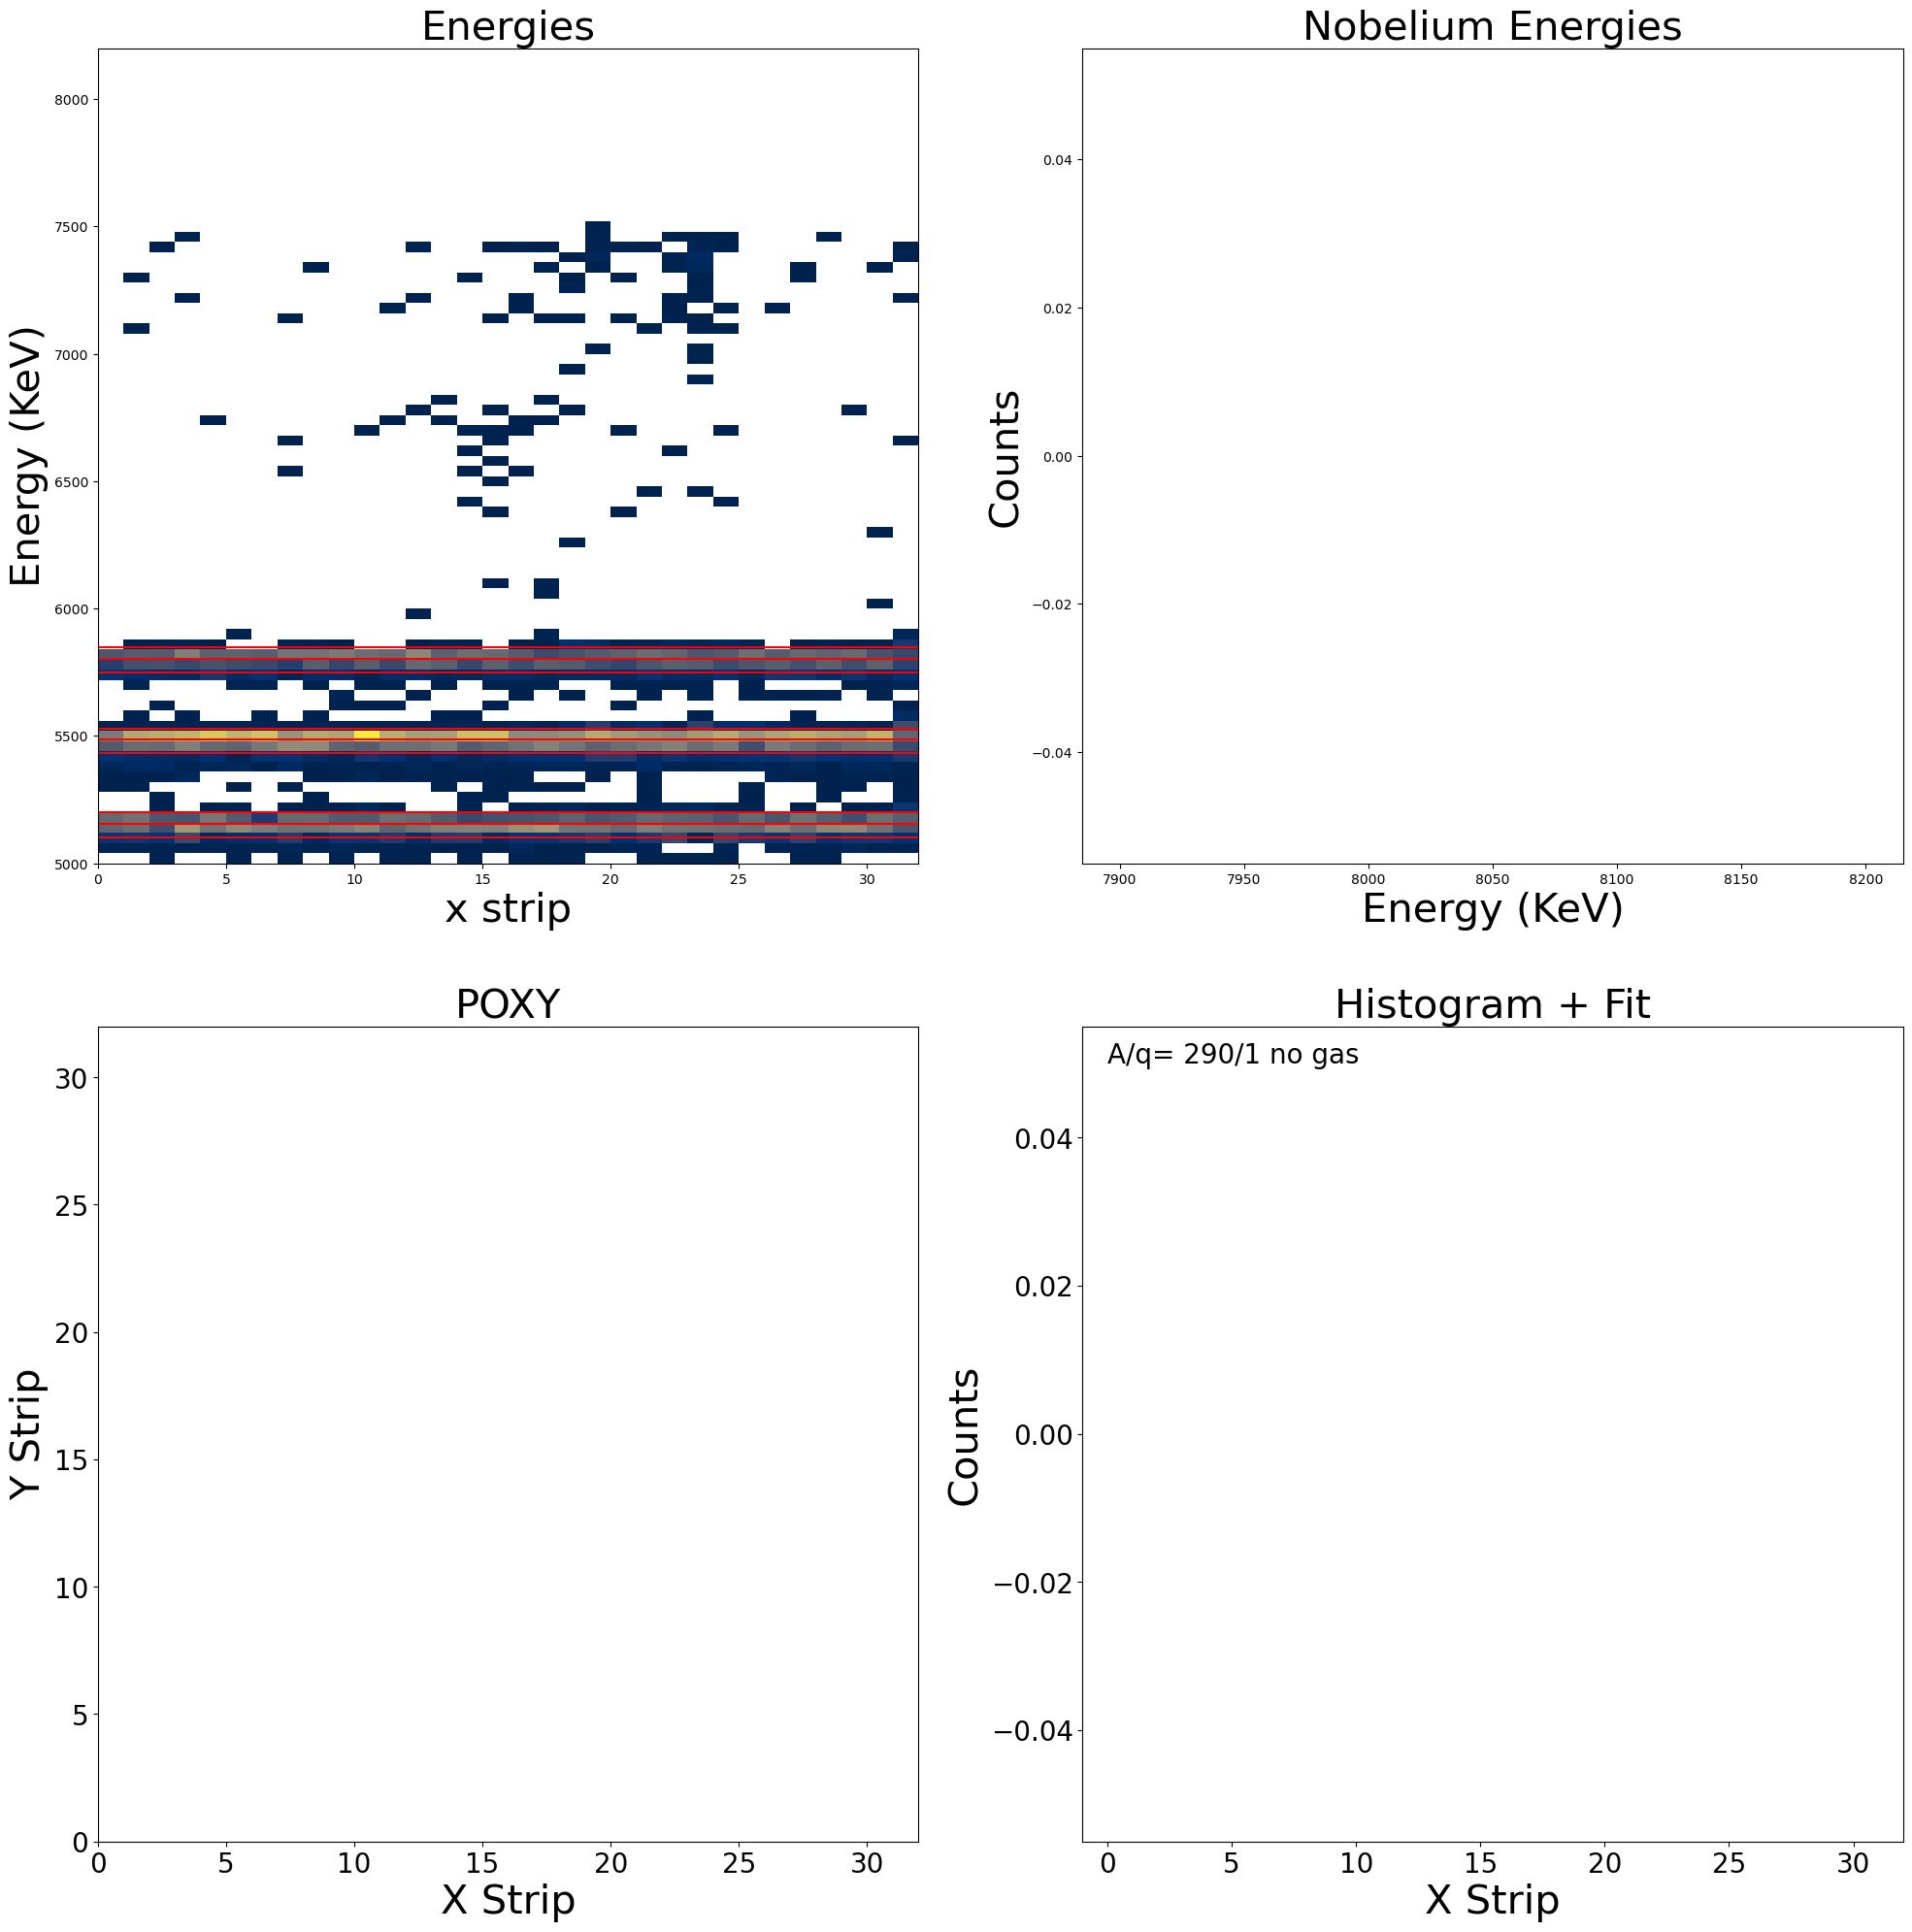

In [34]:
cal = pd.read_csv('run231_calibration_run055.txt', sep = '\t', index_col = 0)
df5, t5 = readDS('run231_066_output.txt', cal)



### checking the energies
plt.figure(figsize = (24,24))
plt.axes().set_aspect('equal')
plt.subplot(2,2,1)
plt.hist2d(df5['x'], df5['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Creating the gated data and bining
gates_5 = df5[(df5['y'] >=0) & (df5['y'] < 31) & (df5['xE'] > 7900) & (df5['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(xbins,0)
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

### Checking Nobelium Energy 
plt.subplot(2,2,2)
plt.hist(gates_5['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,2,3)
plt.hist2d(gates_5['x'], gates_5['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)


### histogram 
counts,bins = np.histogram(gates_5['x'],bins = xbins)
newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
yy= twopeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=twopeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
#print(yy)
plt.subplot(2,2,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.hist(gates_5['x'], bins = newBins,align='left', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(0,0.05, "A/q= 290/1 no gas", fontsize = 20)

#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.show()






### f078,  No$F_{2}$, 292/1

<bound method NDFrame._add_numeric_operations.<locals>.max of 0            0.052401
1            0.057278
2            0.080283
3            0.082855
4            0.094327
             ...     
451166    7270.868451
451167    7270.873405
451168    7270.873405
451169    7270.873405
451170    7270.873405
Name: t, Length: 451171, dtype: float64>


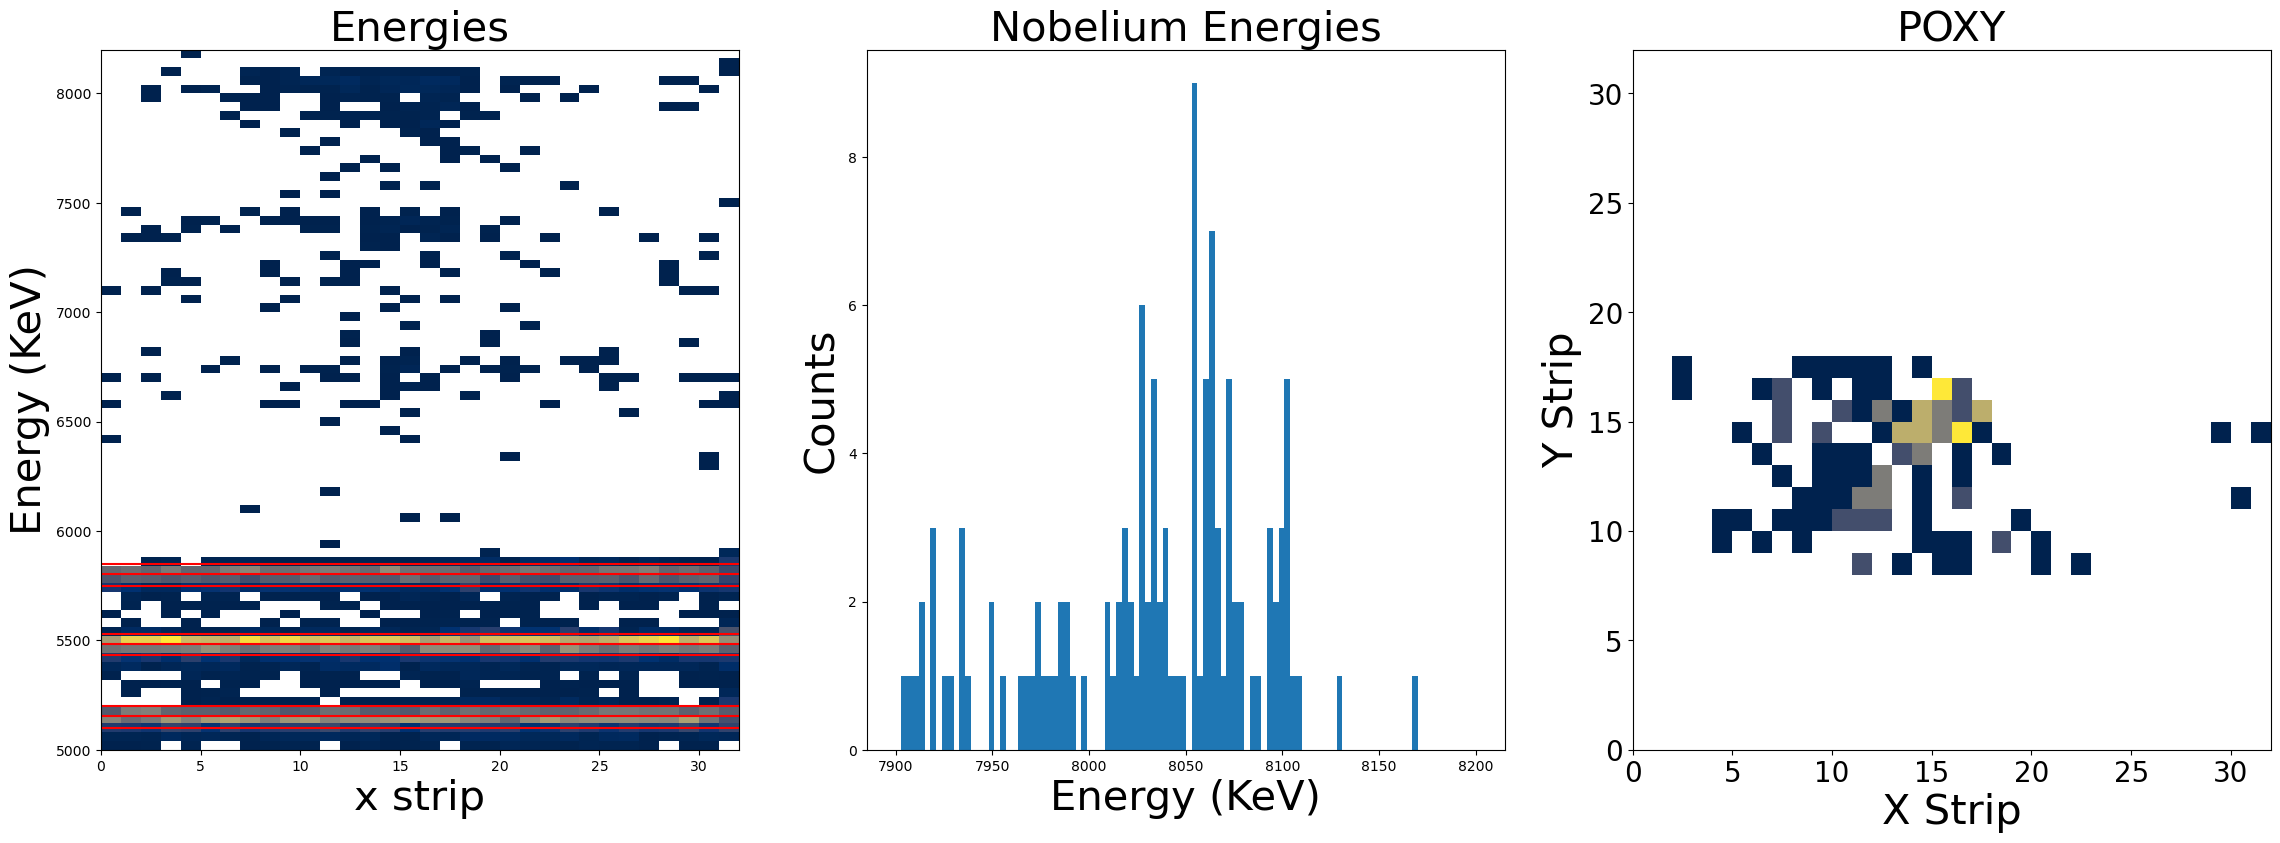

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.27 (chi2/ndof = 1.0)    │              Nfcn = 390              │
│ EDM = 4.38e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─

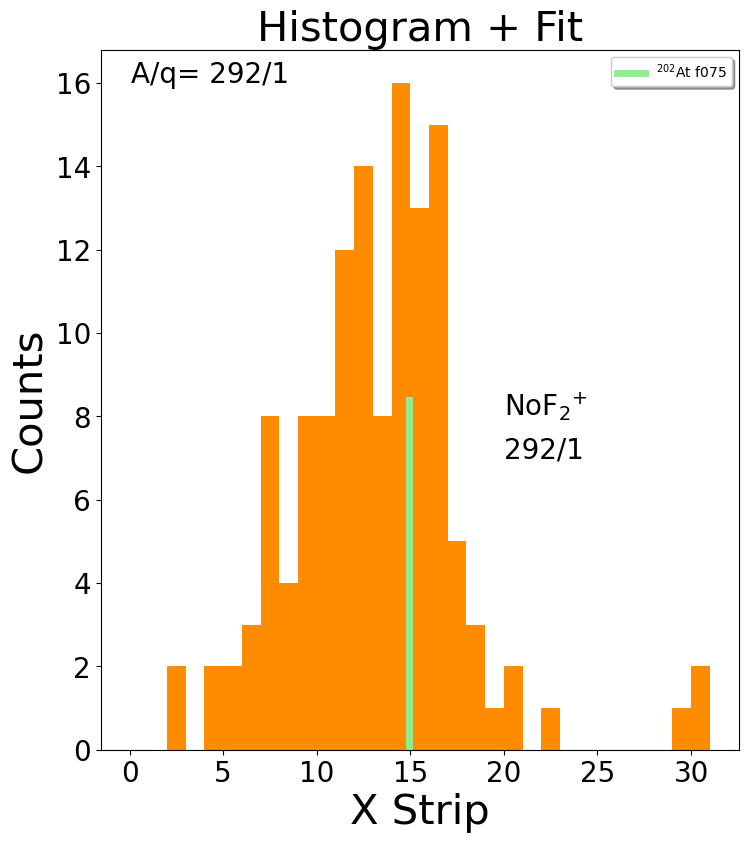

 Number of Rutherfords? = 62762.0000000000
 Counts per 1k ruth flouride? = 2.0713170390 (+/-) 0.1818545691


In [35]:
cal = pd.read_csv('run231_calibration_run075.txt', sep = '\t', index_col = 0)
df6, t6 = readDS('run231_078_output.txt', cal)
data_1 = pd.read_csv('run231_078_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])

print (data_1['t'].max)



### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df6['x'], df6['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Creating the gated data and bining
gates_6 = df6[(df6['y'] >=8) & (df6['y'] < 18) & (df6['xE'] > 7800) & (df6['xE']<8400)]
#gates_6 = df6[(df6['y'] >=0) & (df6['y'] < 31) & (df6['xE'] > 7800) & (df6['xE']<8400)]



### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_6['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates_6['x'], gates_6['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram 
xbins = range(0,32)
hist= plt.hist(gates_6['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye= np.sqrt(newcounts)
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.bar(bins,counts, width=1.0,color='darkorange')


from scipy.special import erf
def skewed_gaussian(x, mu, sigma, alpha, amplitude):
    norm_pdf =amplitude*np.exp(-0.5 * ((x - mu) / sigma) ** 2)*(1 + erf(alpha * (x - mu) / (sigma * np.sqrt(2))))
    return   norm_pdf

def likelihood(mu, sigma, alpha, amplitude):
    # Calculate the negative log-likelihood (or chi-square)
    neg_log_likelihood = -np.sum(np.log(skewed_gaussian(newBins_change, mu, sigma, alpha, amplitude)))
    return neg_log_likelihood

c = cost.LeastSquares(newBins_change,newcounts,ye,skewed_gaussian)


m= minuit.Minuit(c,mu=15, sigma=1.0, alpha=1.0, amplitude=16)
m.limits = [(10,20),(0,5),(-np.inf,10),(0,None)]

m.migrad()
print (m.migrad())
best_fit_mu = m.values['mu']
best_fit_sigma = m.values['sigma']
best_fit_alpha = m.values['alpha']
best_fit_amplitude = m.values['amplitude']


#plt.plot(bins_-0.5, skewed_gaussian(bins_, best_fit_mu, best_fit_sigma, best_fit_alpha, best_fit_amplitude))





plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(20,8, "NoF$_{2}$$^{+}$", fontsize = 20)
plt.text(20,7, "292/1", fontsize = 20)

plt.text(.1,16, "A/q= 292/1", fontsize = 20)
plt.axvline(14.91,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f075')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.show()



#area1_10,_=scipy.integrate.quad(skewed_gaussian,0, 32, args=(best_fit_sigma, best_fit_mu, best_fit_alpha,best_fit_amplitude))
area1_10=sum(newcounts)





### Rutherford Number, East
dfR_6, t1R_6= readRuth('run231_078_output_Ruth.txt', 'ruthE')
print(" Number of Rutherfords? = %0.10f" % len(dfR_6))

### CPR
CPR_6 = area1_10/len(dfR_6)*1000
error_CPR_6=CPR_6*np.sqrt(1/area1_10+1/len(dfR_6))



print(" Counts per 1k ruth flouride? = %0.10f (+/-) %0.10f" % (CPR_6,error_CPR_6 ))



       




In [36]:
## both Fluorides overlayed, normalized

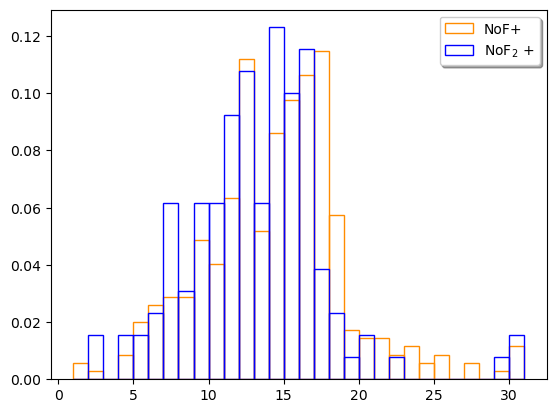

In [37]:
plt.hist(gates_4['x'], bins = newBins,align='mid', ec = 'darkorange', density = 1,fill=False,label="NoF+")
plt.hist(gates_6['x'], bins = newBins,align='mid', ec = 'blue', density = 1,fill=False,label="NoF$_{2}$ +")
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.show()


## f081, NoF$^{2+}$, proving it is not coming in as a +2

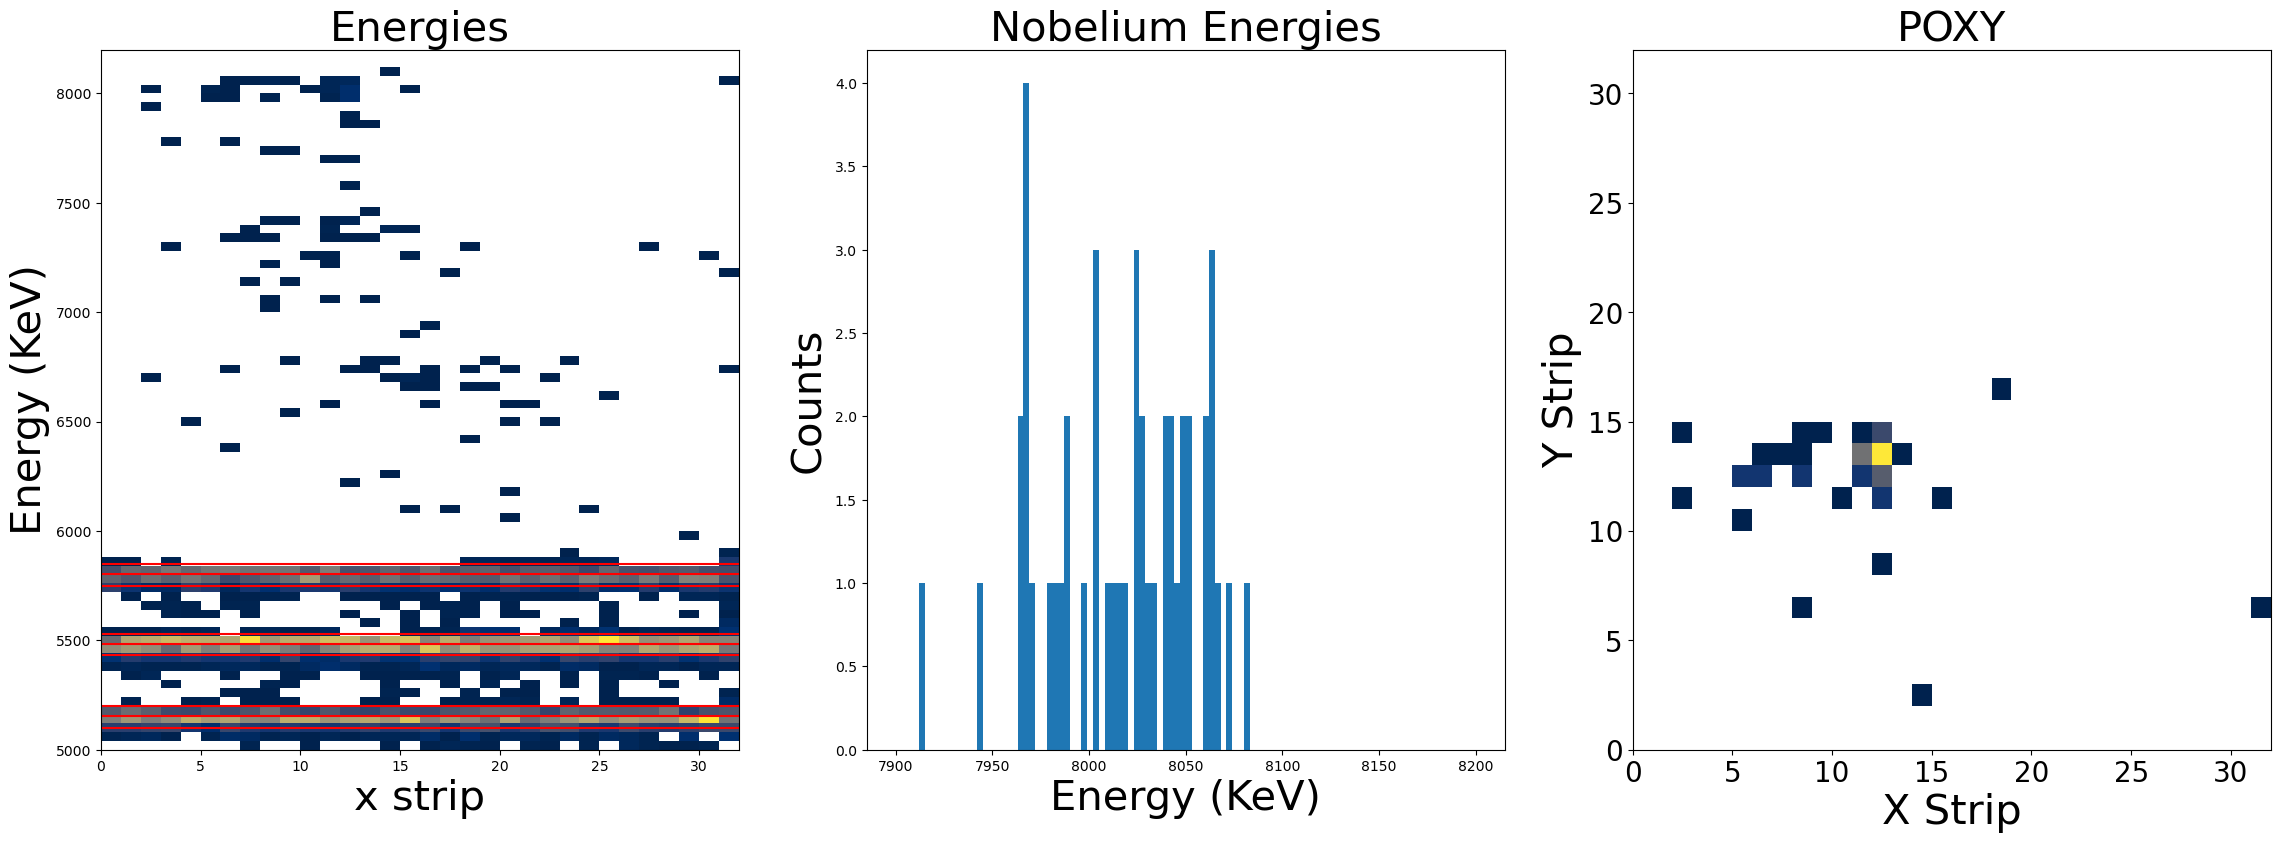

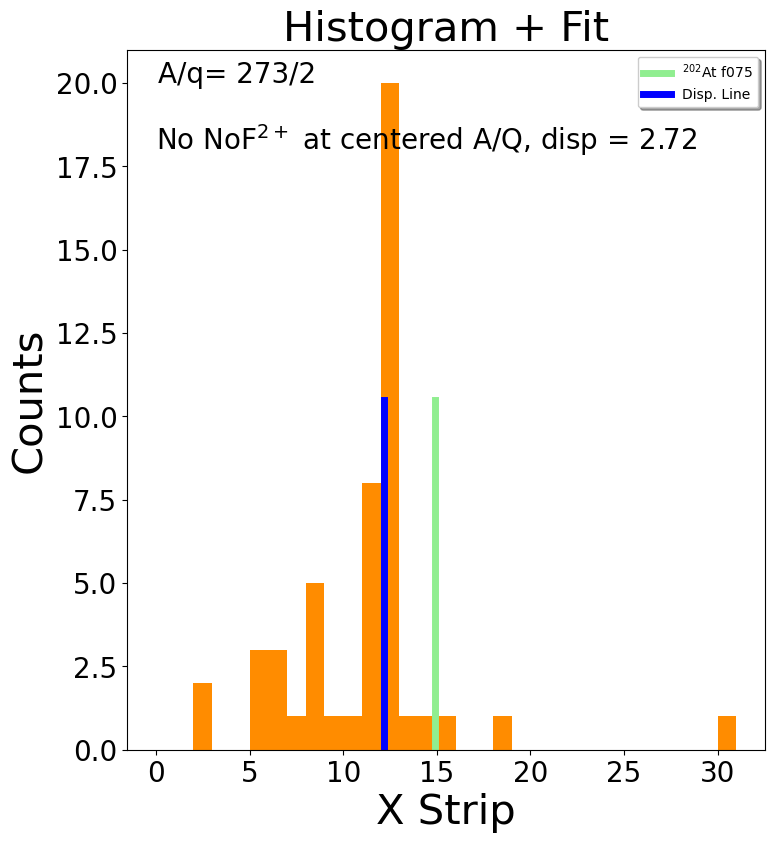

In [38]:
cal = pd.read_csv('run231_calibration_run075.txt', sep = '\t', index_col = 0)
df6_p1, t6_p1 = readDS('run231_081_output.txt', cal)



### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df6_p1['x'], df6_p1['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Creating the gated data and bining
gates_6_p1 = df6_p1[(df6_p1['y'] >=0) & (df6_p1['y'] < 31) & (df6_p1['xE'] > 7800) & (df6_p1['xE']<8400)]

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_6_p1['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates_6_p1['x'], gates_6_p1['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram
xbins = range(0,32)
hist= plt.hist(gates_6_p1['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(.1,20, "A/q= 273/2", fontsize = 20)
plt.text(.01,18, "No NoF$^{2+}$ at centered A/Q, disp = 2.72", fontsize = 20)
plt.axvline(14.91,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f075')
plt.axvline(12.19,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp. Line')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.show()









# using 272/2 as a baseline for the 2+ flouride

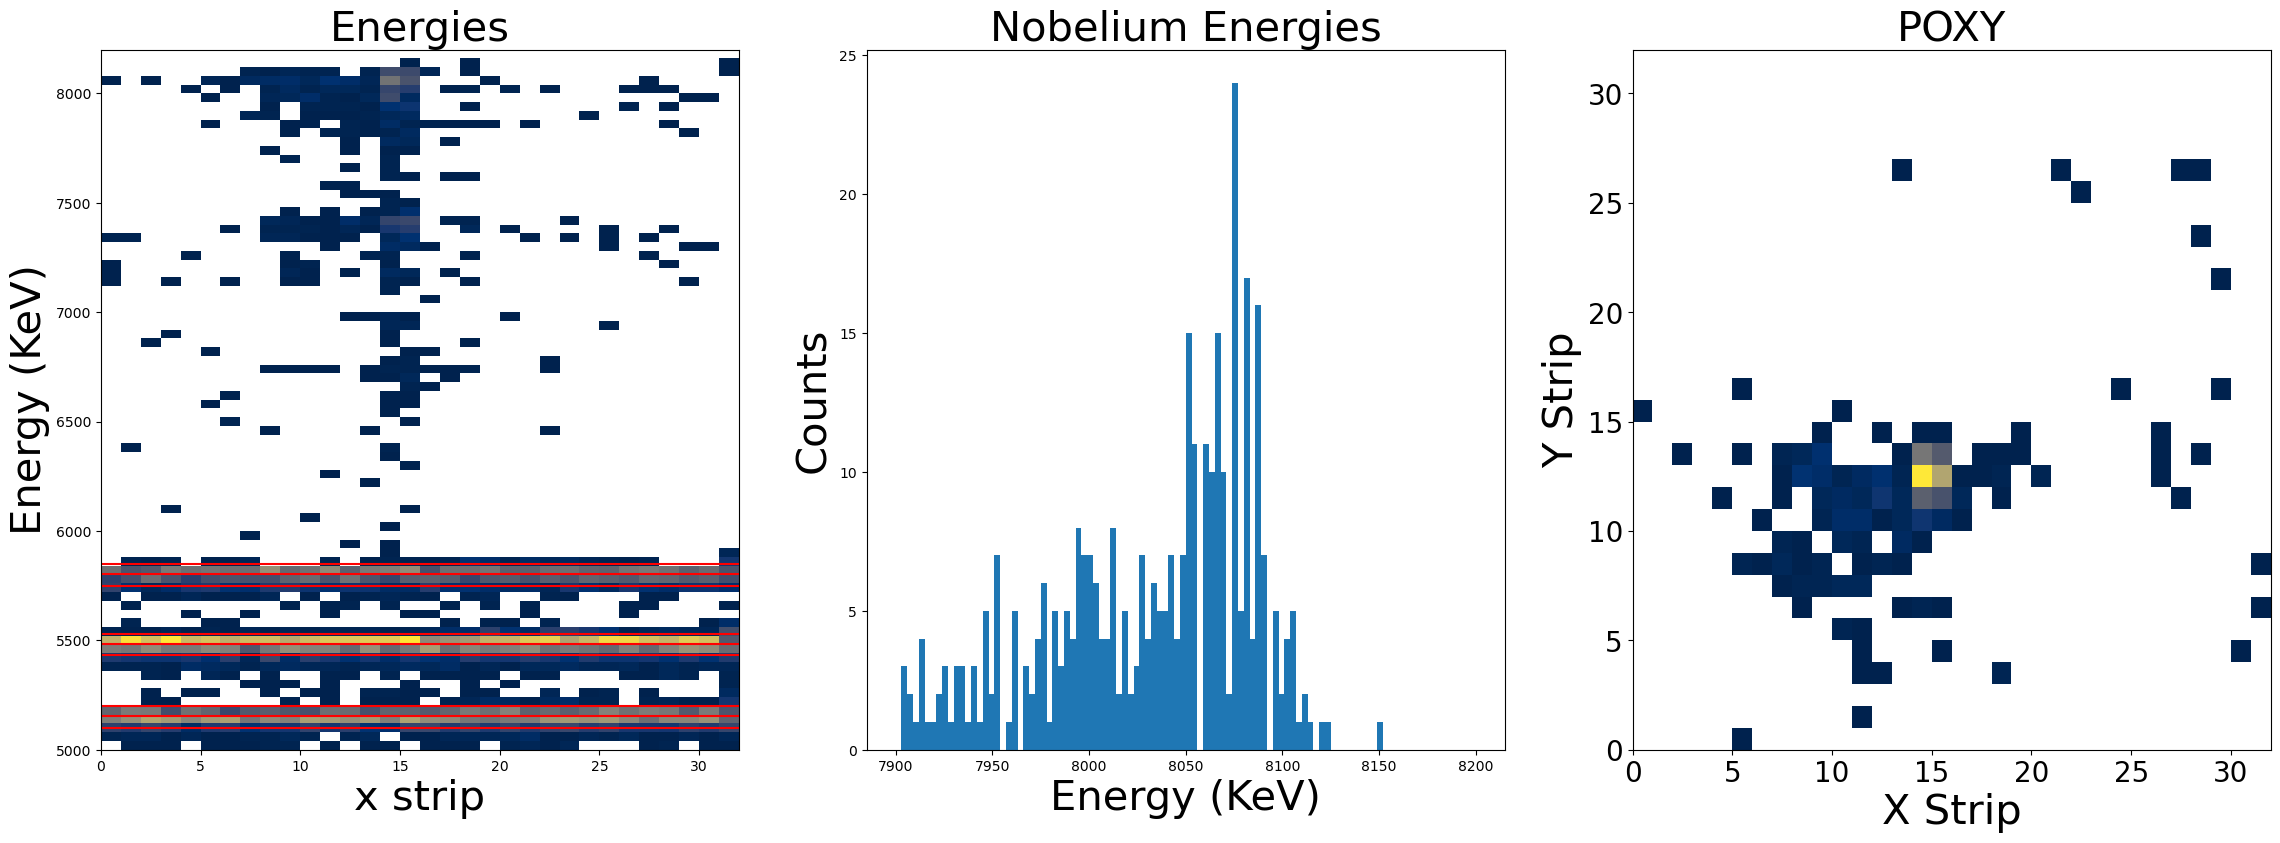

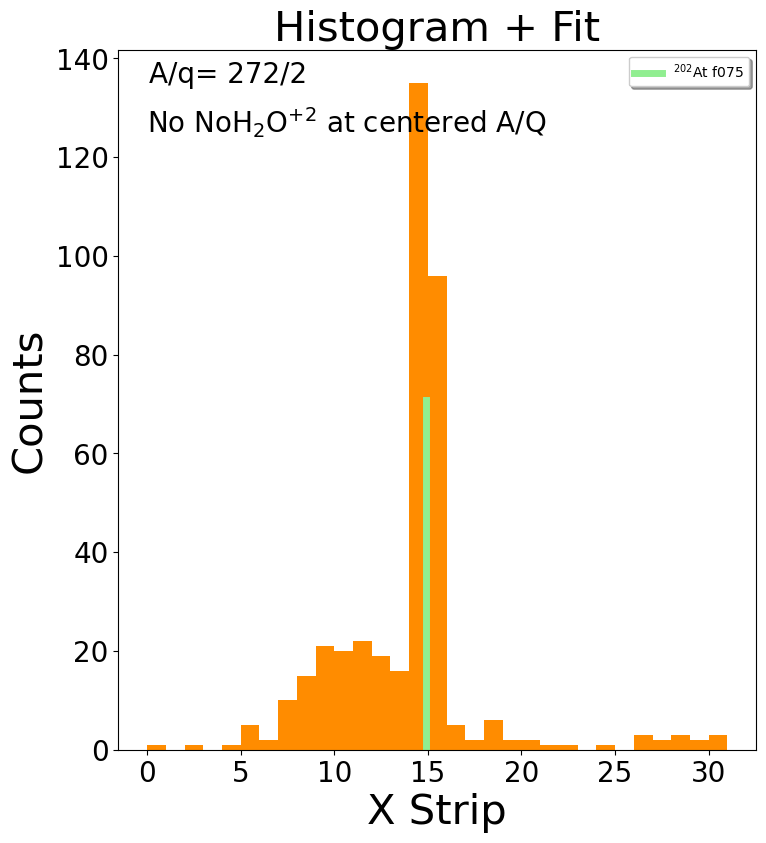

In [39]:
cal = pd.read_csv('run231_calibration_run075.txt', sep = '\t', index_col = 0)
df11, t11 = readDS('run231_050_output.txt', cal)



### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df11['x'], df11['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

### Creating the gated data and bining
gates_11 = df11[(df11['y'] >=0) & (df11['y'] < 31) & (df11['xE'] > 7800) & (df11['xE']<8400)]

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_11['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY hist
plt.subplot(2,3,3)
plt.hist2d(gates_11['x'], gates_11['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram
xbins = range(0,32)
hist= plt.hist(gates_11['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(.1,135, "A/q= 272/2", fontsize = 20)
plt.text(.01,125, "No NoH$_{2}$O$^{+2}$ at centered A/Q", fontsize = 20)
plt.axvline(14.91,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f075')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.show()









# Bare Ions, no gas

### 254/1, no gas

In [40]:
### In Butane_Reduction_FINAL Notebook

## 254/2, no gas

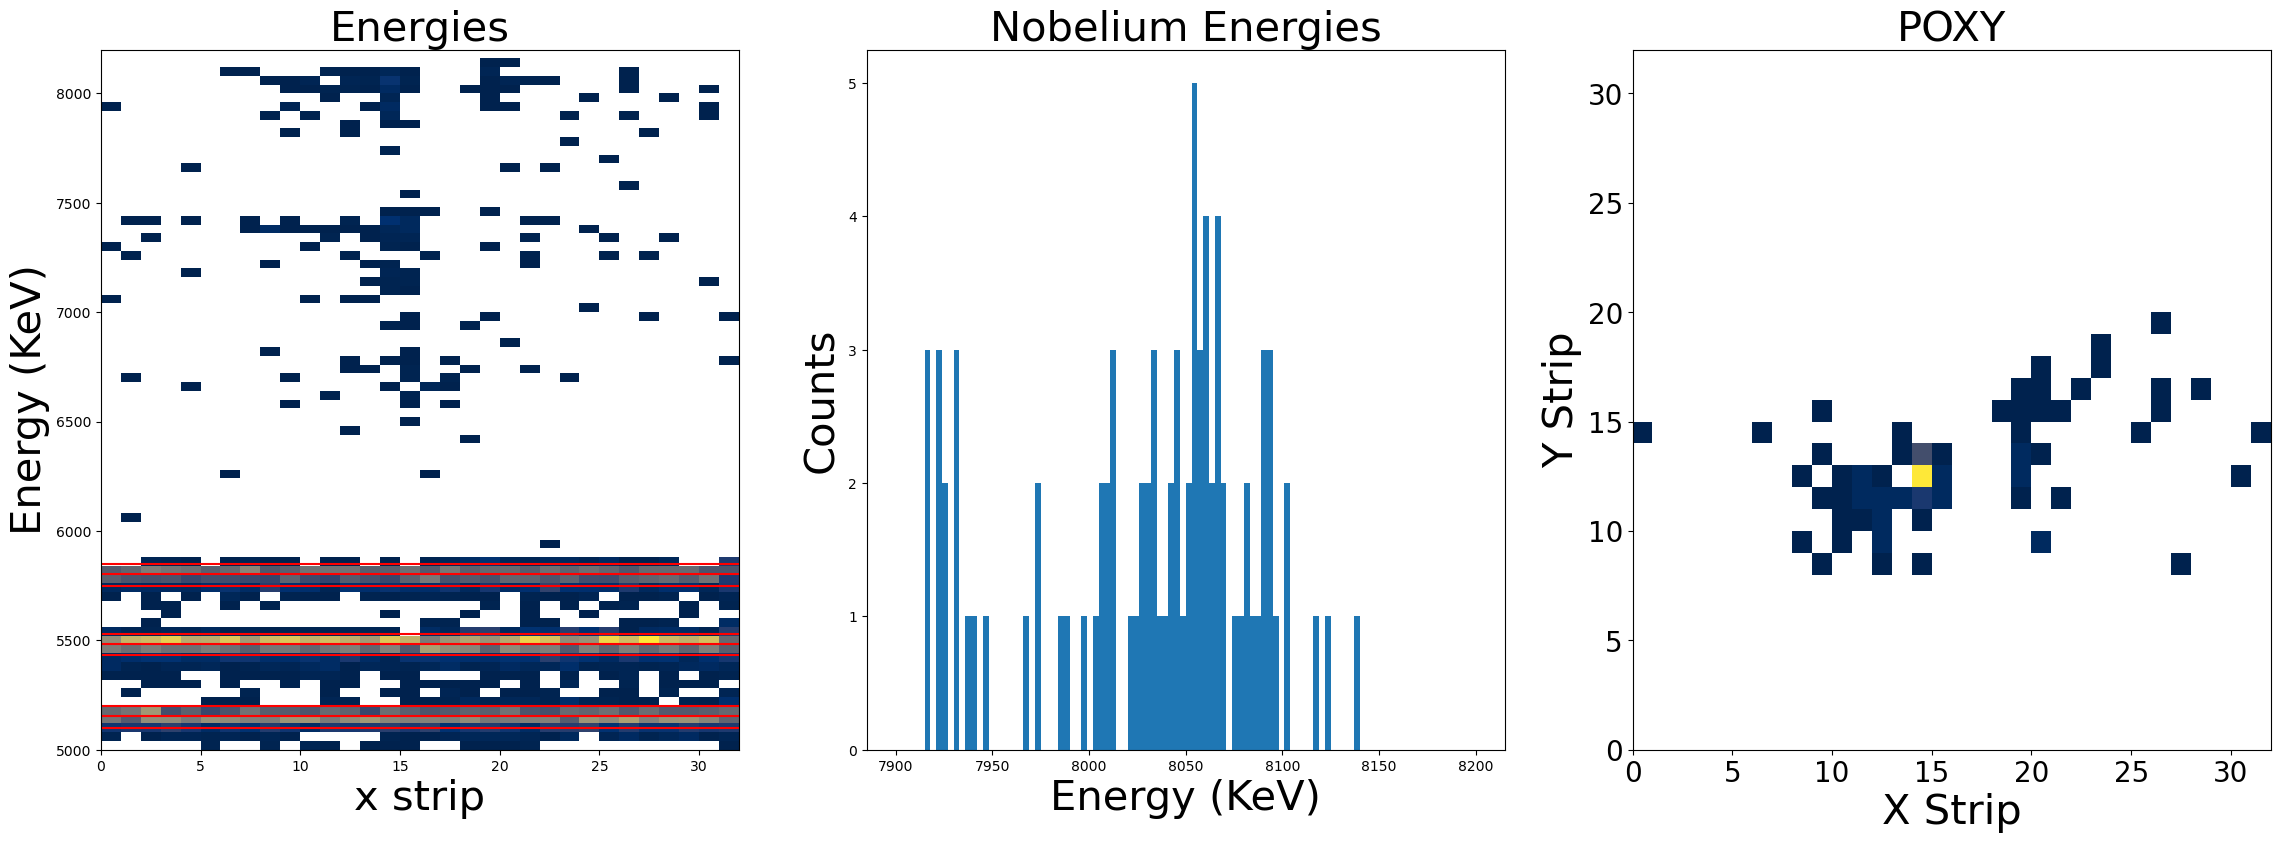

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100
 Number of Rutherfords? = 36622.0000000000
 Counts per 1k ruth (CPR_8)= 2.7305990934
0.27343246376375274


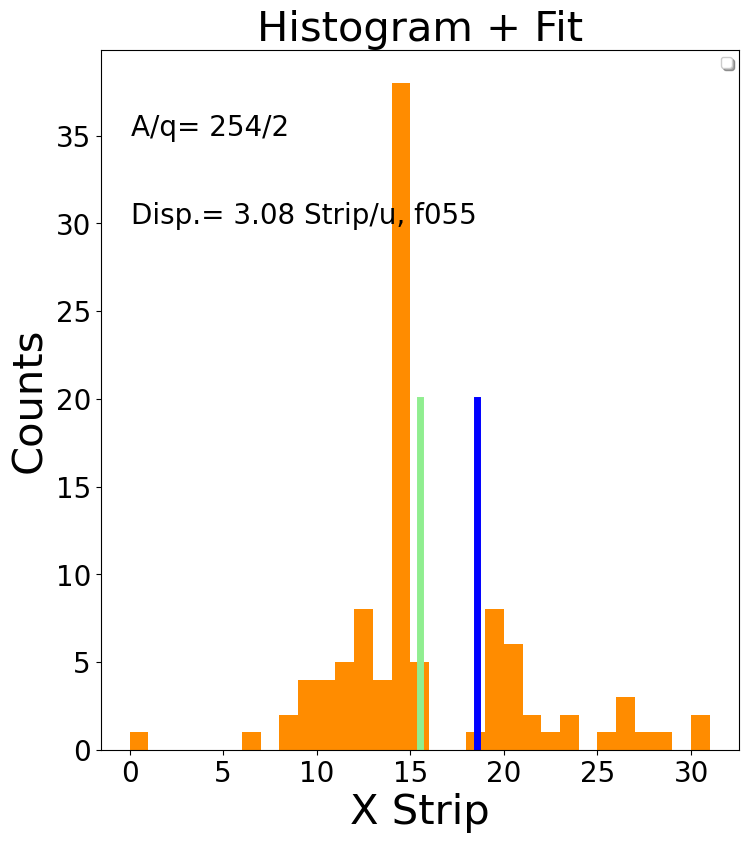

In [41]:
cal = pd.read_csv('run231_calibration_run055.txt', sep = '\t', index_col = 0)

df8, t1_8 = readDS('run231_052_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df8['x'], df8['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_8 = df8[(df8['y'] >=7) & (df8['y'] < 21) & (df8['xE'] > 7700) & (df8['xE']<8400)]


### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_8['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,3,3)
plt.hist2d(gates_8['x'], gates_8['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram 
xbins = range(0,32)
hist= plt.hist(gates_8['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
#print(yy)
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.text(.1,35, "A/q= 254/2", fontsize = 20)
plt.text(.1,30, "Disp.= 3.08 Strip/u, f055", fontsize = 20)
plt.axvline(15.5,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f055')
plt.axvline(18.58,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp.Line f055')







### How many counts in peak, area of the peak
area1_11=sum(newcounts)
print (area1_11)


### Rutherford Number, East
dfRuth_8, t1Ruth_8 = readRuth('run231_052_output_Ruth.txt', 'ruthE')
print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_8)))

### Counts per 1k ruth (CPR)
CPR_8 = area1_11/len(dfRuth_8)*1000
error_CPR_8= CPR_8*np.sqrt(1/area1_11+1/len(dfRuth_8))


print(" Counts per 1k ruth (CPR_8)= %0.10f" % (CPR_8))
print (error_CPR_8)



## F022, 254/2

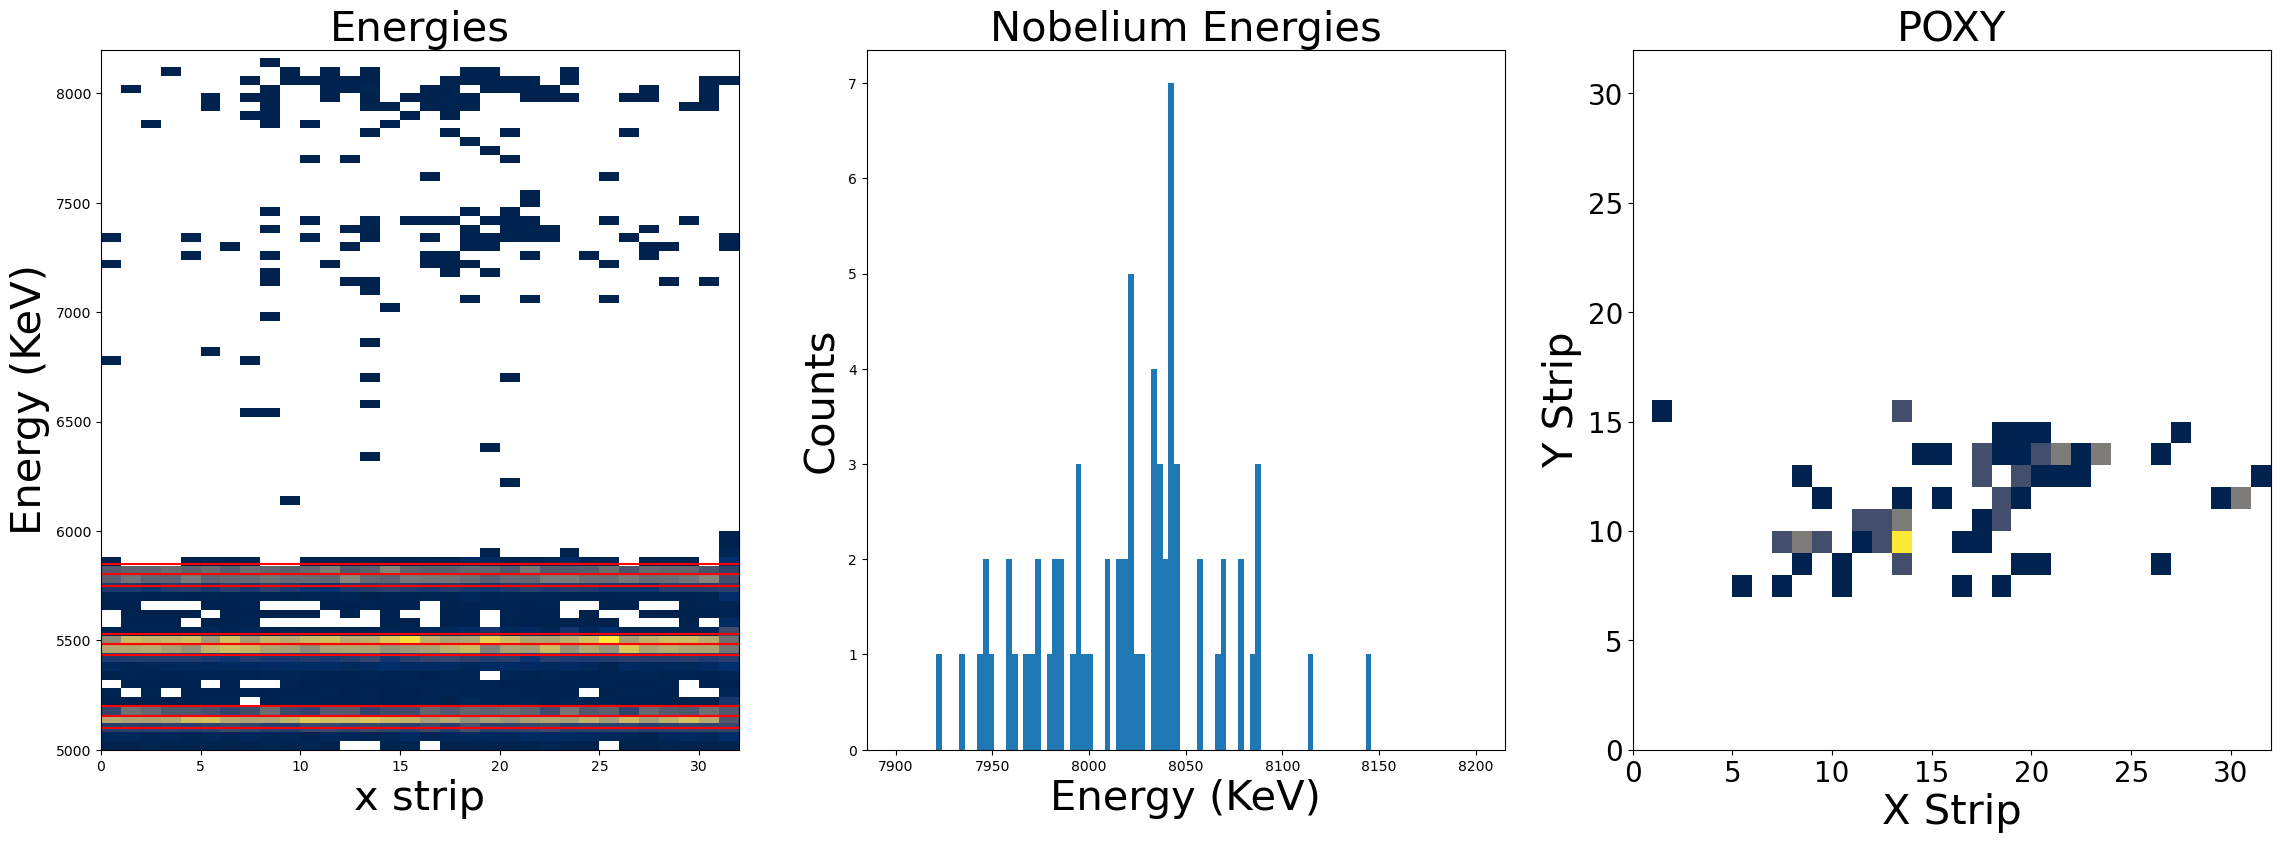

81
 Number of Rutherfords? = 136778.0000000000
 Counts per 1k ruth = 0.5922005001
0.06581953609372874


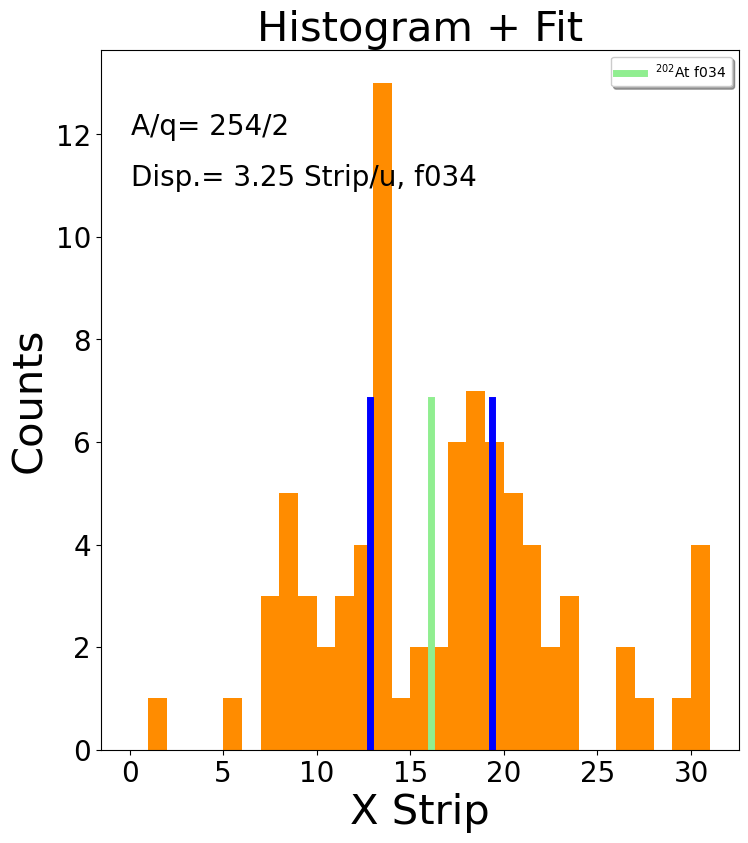

In [42]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

df9_1, t9_1 = readDS('run231_022_output.txt', cal)
df9_2, t9_2 = readDS('run231_022_2_output.txt', cal)
df9 = pd.concat([df9_1,df9_2])
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df9['x'], df9['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_9 = df9[(df9['y'] >=7) & (df9['y'] < 16) & (df9['xE'] > 7700) & (df9['xE']<8400)]


### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_9['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,3,3)
plt.hist2d(gates_9['x'], gates_9['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram 
xbins = range(0,32)
hist= plt.hist(gates_9['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.axvline(16.12,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f034')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.text(.1,12, "A/q= 254/2", fontsize = 20)
plt.text(.1,11, "Disp.= 3.25 Strip/u, f034", fontsize = 20)
plt.axvline(19.37,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp. Line')
plt.axvline(12.87,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='$^{202}$At f034')







### How many counts in peak, area of the peak
area1_12=sum(newcounts)
print (area1_12)


### Rutherford Number, East
dfRuth_9_1, t1Ruth_9_1 = readRuth('run231_022_output_Ruth.txt', 'ruthE')
dfRuth_9_2, t1Ruth_9_2 = readRuth('run231_022_output_2_Ruth.txt', 'ruthE')
dfRuth_9 = pd.concat([dfRuth_9_1,dfRuth_9_2])


print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_9)))

### Counts per 1k ruth (CPR)
CPR_9 = area1_12/len(dfRuth_9)*1000
error_CPR_9= CPR_9*np.sqrt(1/area1_12+1/len(dfRuth_9))
print(" Counts per 1k ruth = %0.10f" % (CPR_9))
print (error_CPR_9)



## F030, 254/2

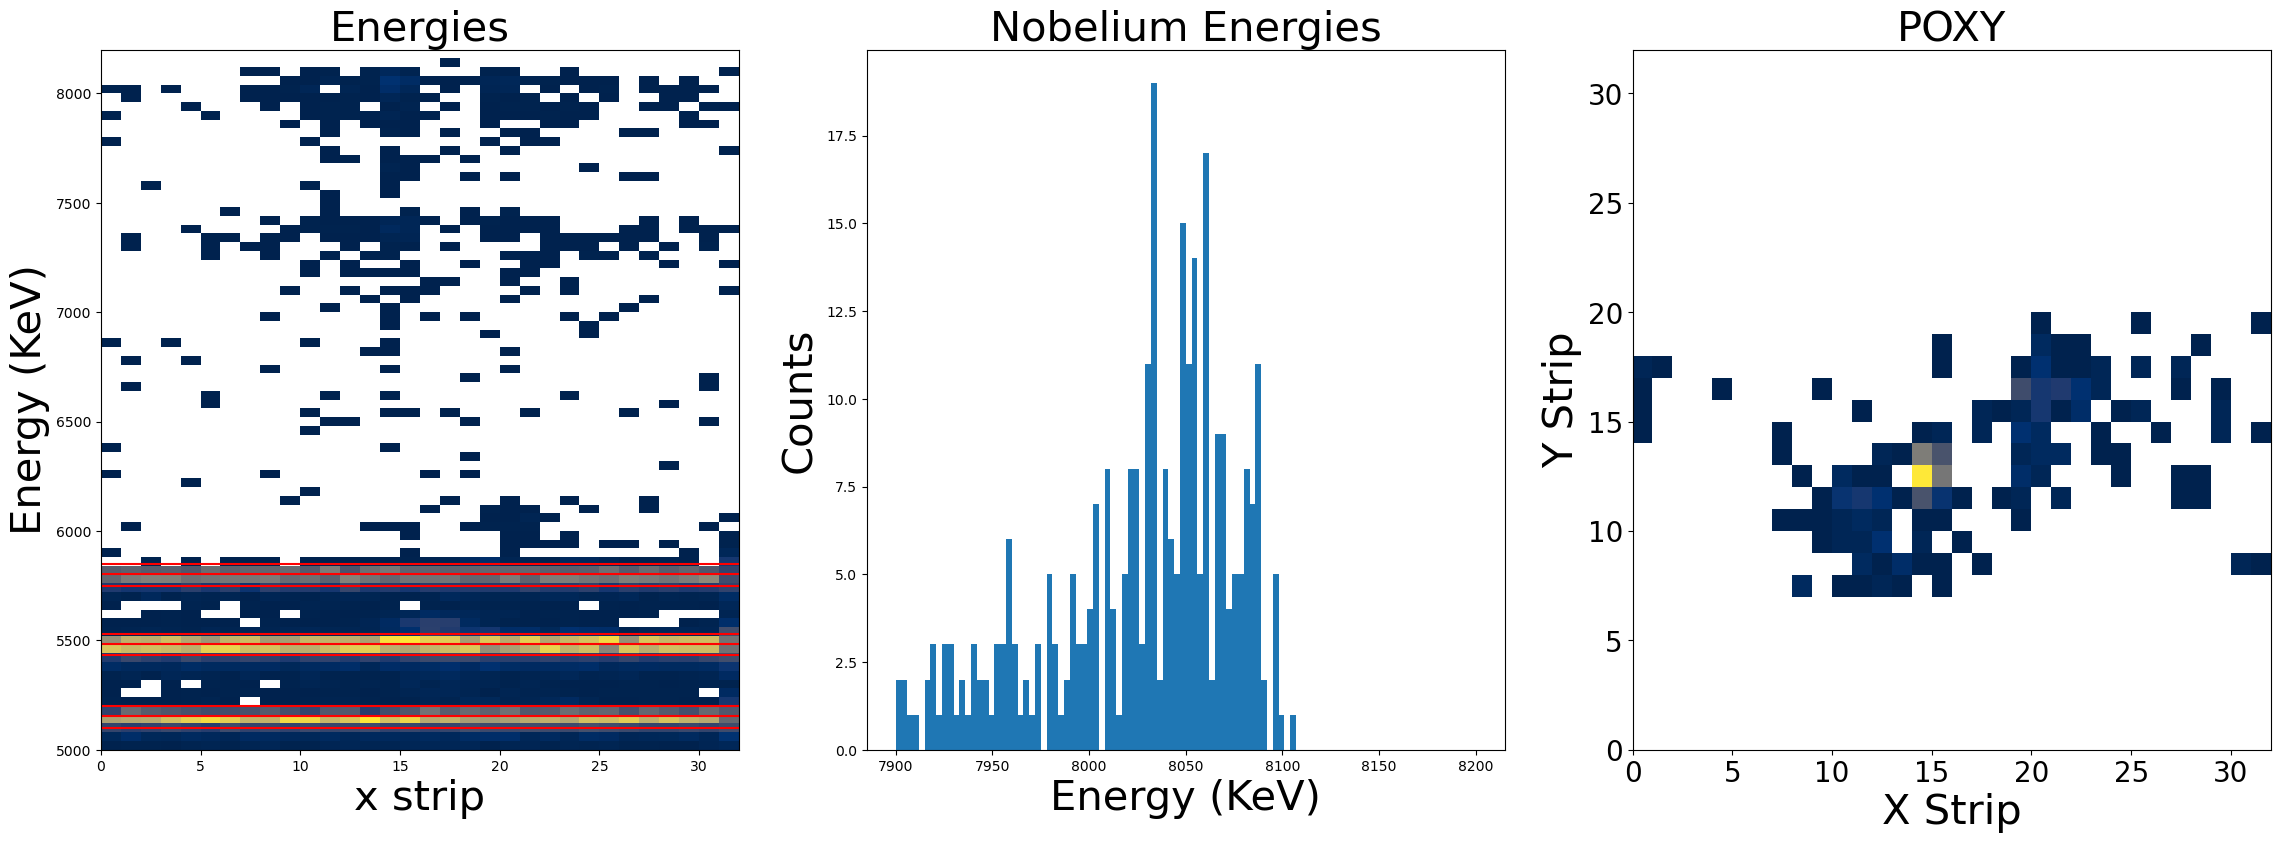

358
 Number of Rutherfords? = 177233.0000000000
 Counts per 1k ruth (CPR_10)= 2.0199398532
0.10686490560971385


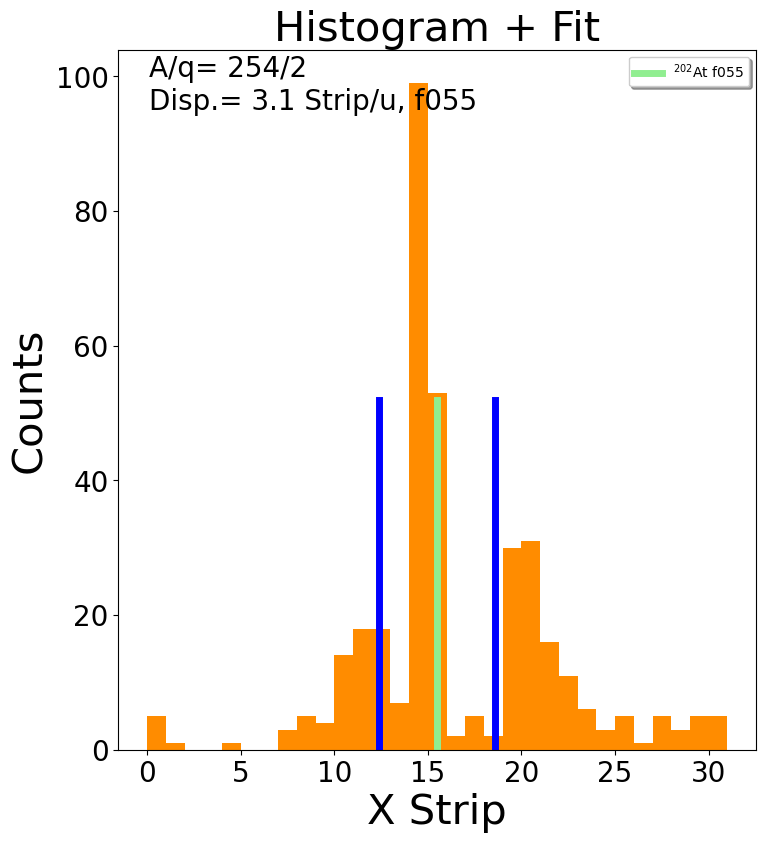

In [43]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

df10, t1_10 = readDS('run231_030_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df10['x'], df10['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_10 = df10[(df10['y'] >=7) & (df10['y'] < 21) & (df10['xE'] > 7700) & (df10['xE']<8400)]

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_10['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,3,3)
plt.hist2d(gates_10['x'], gates_10['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram
xbins = range(0,32)
hist= plt.hist(gates_10['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
#print(yy)
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.axvline(15.5,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f055')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)
plt.text(.1,100, "A/q= 254/2", fontsize = 20)
plt.text(.1,95, "Disp.= 3.1 Strip/u, f055", fontsize = 20)
plt.axvline(12.4,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp Line')
plt.axvline(18.6,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp. Line')







### How many counts in peak, area of the peak
area1_12=sum(newcounts)
print (area1_12)


### Rutherford Number, East
dfRuth_10, t1Ruth_10 = readRuth('run231_030_output_Ruth.txt', 'ruthE')
print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_10)))

### Counts per 1k ruth (CPR)
CPR_10 = area1_12/len(dfRuth_10)*1000
error_CPR_10= CPR_10*np.sqrt(1/area1_12+1/len(dfRuth_10))
print(" Counts per 1k ruth (CPR_10)= %0.10f" % (CPR_10))
print (error_CPR_10)



##### Product ratios

In [47]:
from IPython.display import clear_output
%run Butane_Reduce_Final.ipynb 
clear_output()

# Butane
CPR_Methide 
error_CPR_Methide
#print (error_CPR_Methide)

area_Hydride
error_CPR_hyrdie
#print (error_CPR_hyrdie)

No_oneplus_produced
#print (No_oneplus_produced)
error_No_oneplus_produced



CPR_No_oneplus_nogas_hydride 
error_CPR_No_oneplus_nogas_hydride
#print (error_CPR_No_oneplus_nogas_hydride)


CPR_Hydride_background_sub=area_Hydride-CPR_No_oneplus_nogas_hydride
error_CPR_Hydride_background_sub= np.sqrt(error_CPR_hyrdie**2+error_CPR_No_oneplus_nogas_hydride**2)
#print (error_CPR_Hydride_background_sub)


Total_butane=No_oneplus_produced+CPR_Hydride_background_sub+CPR_Methide
#
print (Total_butane)
error_Total_butane=np.sqrt(error_CPR_Hydride_background_sub**2+error_CPR_Methide**2+error_CPR_No_oneplus_nogas_hydride**2)
#print (error_Total_butane)

perc_methide=CPR_Methide/Total_butane*100
error_perc_methide=perc_methide*np.sqrt((error_CPR_Methide/CPR_Methide)**2+(error_Total_butane/Total_butane)**2)
#print (error_perc_methide)

perc_hydride=CPR_Hydride_background_sub/Total_butane*100
error_perc_hydride=perc_hydride*np.sqrt((error_CPR_Hydride_background_sub/CPR_Hydride_background_sub)**2+(error_Total_butane/Total_butane)**2)
#print (error_perc_hydride)

perc_reduction=No_oneplus_produced/Total_butane*100
error_reduction=perc_reduction*np.sqrt((error_No_oneplus_produced/No_oneplus_produced)**2+(error_Total_butane/Total_butane)**2)
#print (error_perc_methide)

print(" Percentage of Methide= %0.10f  (+/-) %0.10f" % (perc_methide,error_perc_methide))
print(" Percentage of Hydride= %0.10f  (+/-) %0.10f" % (perc_hydride,error_perc_hydride))
print(" Percentage of Reduction= %0.10f  (+/-) %0.10f" % (perc_reduction,error_reduction))
print(" CPR(1k) Methide= %0.10f  (+/-) %0.10f" % (CPR_Methide,error_CPR_Methide))
print(" CPR(1k) Hydride= %0.10f  (+/-) %0.10f" % (CPR_Hydride_background_sub,error_CPR_Hydride_background_sub))
print(" CPR(1k) reduction= %0.10f  (+/-) %0.10f" % (No_oneplus_produced,error_No_oneplus_produced))













0.5236842792657647
 Percentage of Methide= 11.6089796163  (+/-) 3.1822462595
 Percentage of Hydride= 42.4121138660  (+/-) 10.3818055094
 Percentage of Reduction= 45.9789065177  (+/-) 35.3510564177
 CPR(1k) Methide= 0.0607944012  (+/-) 0.0154152806
 CPR(1k) Hydride= 0.2221055728  (+/-) 0.0492015409
 CPR(1k) reduction= 0.2407843052  (+/-) 0.1834216214


In [46]:
from IPython.display import clear_output
%run Butane_Reduce_Final.ipynb 
clear_output()




# Fluoride
CPR_monoF=CPR_4
error_CPR_monoF=error_CPR_4
CPR_diF=CPR_6
error_CPR_diF=error_CPR_6


total_F=CPR_monoF+CPR_diF
error_total_F=np.sqrt(error_CPR_monoF**2+error_CPR_diF**2)

perc_NoF=CPR_monoF/total_F*100
error_perc_NoF=perc_NoF*np.sqrt((error_CPR_monoF/CPR_monoF)**2+(error_total_F/total_F)**2)
perc_NoF2=CPR_diF/total_F*100
error_perc_NoF2=perc_NoF2*np.sqrt((error_CPR_diF/CPR_diF)**2+(error_total_F/total_F)**2)

print(" Percentage of NoF+= %0.10f (+/-) %0.10f" % (perc_NoF,error_perc_NoF))
print(" Percentage of NoF2(+) = %0.10f  (+/-) %0.10f" % (perc_NoF2,error_perc_NoF2))
print("How many NoF2 (+) were produced = %0.10f CPR/1k (+/-) %0.10f " % (CPR_diF, error_CPR_diF))











 Percentage of NoF+= 39.9246072028 (+/-) 3.1208113090
 Percentage of NoF2(+) = 60.0753927972  (+/-) 6.2857813704
How many NoF2 (+) were produced = 2.0713170390 CPR/1k (+/-) 0.1818545691 
